- GazelleOptimizer (Standard)
- LevyFlightGOA (Exploration-focused)
- RouletteWheelGOA (Exploitation-focused)

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
  %pip install torchinfo

In [ ]:
from tqdm.auto import tqdm
import pandas as pd
import numpy as np
import shutil
import torch
from torch import nn
from torchinfo import summary
import cv2
from torch.utils.data import Dataset
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import os
import albumentations as A
import cv2
import zipfile
from torchvision import transforms, datasets
from PIL import Image
import matplotlib.pyplot as plt
from time import perf_counter as timer
import math
from sklearn.metrics import classification_report, confusion_matrix, f1_score, precision_score, recall_score, accuracy_score
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import numpy as np
from typing import Callable, Tuple, Optional, Dict, Any
import matplotlib.pyplot as plt


import numpy as np
import torch
import torch.nn as nn
from typing import Dict, Any, List, Tuple, Optional
import random
from sklearn.model_selection import ParameterSampler
from scipy.stats import uniform, loguniform, randint
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime
import json

In [ ]:
# Your existing data loading code:
train_data_path = "/content/drive/MyDrive/Metal Detection Data/Processed_Data/train"
valid_data_path = "/content/drive/MyDrive/Metal Detection Data/Processed_Data/valid"
test_data_path = "/content/drive/MyDrive/Metal Detection Data/Processed_Data/test"

transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

train_data = datasets.ImageFolder(train_data_path, transform=transform)
valid_data = datasets.ImageFolder(valid_data_path, transform=transform)
test_data = datasets.ImageFolder(test_data_path, transform=transform)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_data, batch_size=32, shuffle=False)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

class_names = train_data.classes
class_dict = train_data.class_to_idx

In [ ]:
class TinyVGG_v2(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int) -> None:
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape, out_channels=hidden_units, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units * 64 * 64, out_features=output_shape),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.conv_block_1(x)
        x = self.conv_block_2(x)
        x = self.classifier(x)
        return x



device = 'cuda' if torch.cuda.is_available() else 'cpu'


model = TinyVGG_v2(
    input_shape=3,
    hidden_units=64,
    output_shape=len(class_names)
).to(device)

print(f"Fixed model parameters: {sum(p.numel() for p in model.parameters())}")

Fixed model parameters: 1685446


## Basic GOA

In [ ]:
# Base GOA Class (extensible for variants)
class GazelleOptimizer:
    def __init__(self,
                 objective_function: Callable,
                 dimension: int,
                 population_size: int = 20,
                 max_iterations: int = 50,
                 bounds: Tuple[float, float] = (-1, 1),
                 alpha: float = 2.0,
                 beta: float = 0.5,
                 variant: str = "standard",
                 random_seed: Optional[int] = None):

        self.objective_function = objective_function
        self.dimension = dimension
        self.population_size = population_size
        self.max_iterations = max_iterations
        self.bounds = bounds
        self.alpha = alpha
        self.beta = beta
        self.variant = variant

        if random_seed is not None:
            np.random.seed(random_seed)
            torch.manual_seed(random_seed)

        self.positions = None
        self.velocities = None
        self.fitness = None
        self.best_position = None
        self.best_fitness = float('inf')
        self.convergence_history = []

    def initialize_population(self):
        self.positions = np.random.uniform(
            self.bounds[0], self.bounds[1],
            (self.population_size, self.dimension)
        )
        self.velocities = np.zeros((self.population_size, self.dimension))

        self.fitness = np.array([
            self.objective_function(pos) for pos in self.positions
        ])

        best_idx = np.argmin(self.fitness)
        self.best_position = self.positions[best_idx].copy()
        self.best_fitness = self.fitness[best_idx]

    def update_gazelle(self, idx: int):
        current_pos = self.positions[idx]
        current_vel = self.velocities[idx]

        # Standard GOA update rules
        if self.variant == "standard":
            acceleration = self.alpha * (self.best_position - current_pos)
            random_motion = self.beta * np.random.uniform(-1, 1, self.dimension)
            new_velocity = current_vel + acceleration + random_motion

        # Add more variants here as needed
        elif self.variant == "enhanced":
            # Example: Enhanced variant with adaptive parameters
            adaptive_alpha = self.alpha * (1 - np.mean(self.fitness) / (self.best_fitness + 1e-8))
            acceleration = adaptive_alpha * (self.best_position - current_pos)
            random_motion = self.beta * np.random.normal(0, 0.5, self.dimension)
            new_velocity = 0.9 * current_vel + acceleration + random_motion

        else:
            raise ValueError(f"Unknown variant: {self.variant}")

        new_position = current_pos + new_velocity
        new_position = np.clip(new_position, self.bounds[0], self.bounds[1])

        self.velocities[idx] = new_velocity
        self.positions[idx] = new_position

    def optimize(self, verbose: bool = True):
        self.initialize_population()

        if verbose:
            print(f"GOA ({self.variant}) Optimization Started")
            print(f"Initial Best Fitness: {self.best_fitness:.6f}")
            print("-" * 50)

        for iteration in range(self.max_iterations):
            for i in range(self.population_size):
                self.update_gazelle(i)

            for i in range(self.population_size):
                self.fitness[i] = self.objective_function(self.positions[i])

            best_idx = np.argmin(self.fitness)
            if self.fitness[best_idx] < self.best_fitness:
                self.best_position = self.positions[best_idx].copy()
                self.best_fitness = self.fitness[best_idx]

            self.convergence_history.append(self.best_fitness)

            if verbose and (iteration + 1) % 10 == 0:
                print(f"Iteration {iteration + 1:3d}: Best Fitness = {self.best_fitness:.6f}")

        if verbose:
            print(f"Final Best Fitness: {self.best_fitness:.6f}")

        return {
            'best_position': self.best_position,
            'best_fitness': self.best_fitness,
            'convergence_history': self.convergence_history
        }


In [ ]:
# CNN Trainer with GOA
class GOA_CNN_Trainer:
    def __init__(self,
                 train_loader,
                 valid_loader,
                 test_loader,
                 num_classes,
                 device='cuda' if torch.cuda.is_available() else 'cpu'):

        self.train_loader = train_loader
        self.valid_loader = valid_loader
        self.test_loader = test_loader
        self.num_classes = num_classes
        self.device = device

        # Parameter bounds for GOA optimization
        self.param_bounds = {
            'learning_rate': (1e-5, 1e-1),    # log scale
            'hidden_units': (8, 128),         # linear scale
            'dropout_rate': (0.0, 0.7),       # linear scale
            'weight_decay': (1e-6, 1e-2)      # log scale
        }

    def vector_to_params(self, vector):
        """Convert GOA vector to CNN parameters"""
        params = {}
        params['learning_rate'] = 10 ** (vector[0] * (np.log10(self.param_bounds['learning_rate'][1]) -
                                                      np.log10(self.param_bounds['learning_rate'][0])) +
                                        np.log10(self.param_bounds['learning_rate'][0]))

        params['hidden_units'] = int(vector[1] * (self.param_bounds['hidden_units'][1] -
                                                 self.param_bounds['hidden_units'][0]) +
                                    self.param_bounds['hidden_units'][0])

        params['dropout_rate'] = vector[2] * (self.param_bounds['dropout_rate'][1] -
                                             self.param_bounds['dropout_rate'][0]) + \
                                self.param_bounds['dropout_rate'][0]

        params['weight_decay'] = 10 ** (vector[3] * (np.log10(self.param_bounds['weight_decay'][1]) -
                                                     np.log10(self.param_bounds['weight_decay'][0])) +
                                       np.log10(self.param_bounds['weight_decay'][0]))

        return params

    def train_and_evaluate(self, params, epochs=10):
        """Train CNN with given parameters and return validation loss"""
        # Create model
        model = TinyVGG_v2(input_shape=3,
                       hidden_units=params['hidden_units'],
                       output_shape=self.num_classes).to(self.device)

        # Add dropout to model
        for module in model.modules():
            if isinstance(module, nn.Linear):
                model.classifier = nn.Sequential(
                    nn.Flatten(),
                    nn.Dropout(params['dropout_rate']),
                    nn.Linear(params['hidden_units'] * 64 * 64, self.num_classes)
                ).to(self.device)
                break

        # Setup training
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(model.parameters(),
                                   lr=params['learning_rate'],
                                   weight_decay=params['weight_decay'])

        # Training loop
        model.train()
        for epoch in range(epochs):
            for batch_idx, (data, target) in enumerate(self.train_loader):
                if batch_idx > 20:  # Limit training for faster GOA iterations
                    break

                data, target = data.to(self.device), target.to(self.device)
                optimizer.zero_grad()
                output = model(data)
                loss = criterion(output, target)
                loss.backward()
                optimizer.step()

        # Validation
        model.eval()
        val_loss = 0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for data, target in self.valid_loader:
                data, target = data.to(self.device), target.to(self.device)
                output = model(data)
                val_loss += criterion(output, target).item()
                pred = output.argmax(dim=1)
                val_correct += pred.eq(target).sum().item()
                val_total += target.size(0)

        val_accuracy = val_correct / val_total
        avg_val_loss = val_loss / len(self.valid_loader)

        # Return loss (what GOA minimizes) with penalty for low accuracy
        fitness = avg_val_loss + (1 - val_accuracy) * 0.5
        return fitness, model, val_accuracy

    def objective_function(self, vector):
        """Objective function for GOA"""
        # Ensure vector is in bounds [0, 1]
        vector = np.clip(vector, 0, 1)
        params = self.vector_to_params(vector)
        fitness, _, _ = self.train_and_evaluate(params, epochs=5)  # Short training for GOA
        return fitness

    def run_optimization(self,
                        population_size=10,
                        max_iterations=20,
                        variant="standard",
                        verbose=True):
        """Run GOA optimization"""

        goa = GazelleOptimizer(
            objective_function=self.objective_function,
            dimension=4,  # 4 parameters to optimize
            population_size=population_size,
            max_iterations=max_iterations,
            bounds=(0, 1),  # Normalized bounds
            alpha=2.0,
            beta=0.5,
            variant=variant,
            random_seed=42
        )

        result = goa.optimize(verbose=verbose)

        # Get best parameters
        best_params = self.vector_to_params(result['best_position'])

        # Train final model with best parameters
        print("\nTraining final model with best parameters...")
        print(f"Best parameters: {best_params}")

        final_fitness, final_model, final_accuracy = self.train_and_evaluate(
            best_params, epochs=20
        )

        return {
            'best_params': best_params,
            'final_model': final_model,
            'final_accuracy': final_accuracy,
            'convergence_history': result['convergence_history']
        }

    def test_model(self, model):
        """Test the final model"""
        model.eval()
        test_correct = 0
        test_total = 0

        with torch.no_grad():
            for data, target in self.test_loader:
                data, target = data.to(self.device), target.to(self.device)
                output = model(data)
                pred = output.argmax(dim=1)
                test_correct += pred.eq(target).sum().item()
                test_total += target.size(0)

        test_accuracy = test_correct / test_total
        print(f"Test Accuracy: {test_accuracy:.4f}")
        return test_accuracy

In [ ]:
def run_goa_training(train_loader, valid_loader, test_loader, num_classes, variant="standard"):
    """Main function to run GOA training"""

    # Initialize trainer
    trainer = GOA_CNN_Trainer(
        train_loader=train_loader,
        valid_loader=valid_loader,
        test_loader=test_loader,
        num_classes=num_classes
    )

    # Run optimization
    result = trainer.run_optimization(
        population_size=8,  # Small for faster execution
        max_iterations=15,  # Reasonable number
        variant=variant,
        verbose=True
    )

    # Test final model
    test_accuracy = trainer.test_model(result['final_model'])

    # Plot convergence
    plt.figure(figsize=(10, 6))
    plt.plot(result['convergence_history'], 'b-', linewidth=2)
    plt.title(f'GOA ({variant}) Convergence Curve')
    plt.xlabel('Iteration')
    plt.ylabel('Fitness (Validation Loss + Penalty)')
    plt.grid(True, alpha=0.3)
    plt.show()

    return result, test_accuracy

GOA (standard) Optimization Started
Initial Best Fitness: 0.151109
--------------------------------------------------
Iteration  10: Best Fitness = 0.117336
Final Best Fitness: 0.117336

Training final model with best parameters...
Best parameters: {'learning_rate': np.float64(0.00025668311261085305), 'hidden_units': 90, 'dropout_rate': np.float64(0.3295630493146654), 'weight_decay': np.float64(1e-06)}
Test Accuracy: 0.8750


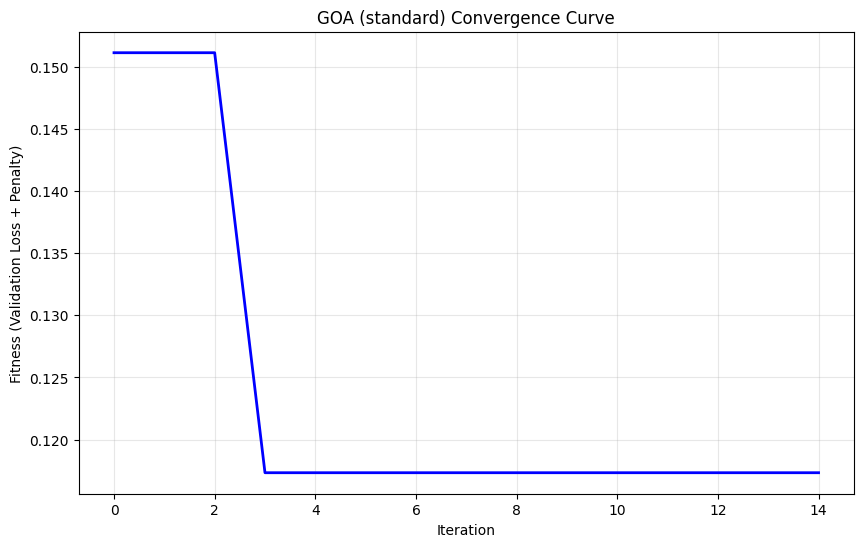

Final test accuracy: 0.8750
Best parameters found: {'learning_rate': np.float64(0.00025668311261085305), 'hidden_units': 90, 'dropout_rate': np.float64(0.3295630493146654), 'weight_decay': np.float64(1e-06)}


In [ ]:
# Your existing data loading code stays the same
batch = 16  # You can change this

# Run GOA training with standard variant
result, test_acc = run_goa_training(
    train_loader, valid_loader, test_loader,
    num_classes=len(class_names),
    variant="standard"
)

# To use enhanced variant:
# result, test_acc = run_goa_training(
#     train_loader, valid_loader, test_loader,
#     num_classes=len(class_names),
#     variant="enhanced"
# )

print(f"Final test accuracy: {test_acc:.4f}")
print(f"Best parameters found: {result['best_params']}")

In [ ]:
def get_training_accuracy(model, train_loader, device='cuda' if torch.cuda.is_available() else 'cpu'):
    """
    Evaluate the trained model on training data to get training accuracy

    Args:
        model: Your trained TinyVGG model
        train_loader: Your training data loader
        device: Device to run evaluation on

    Returns:
        training_accuracy: Accuracy on training set
    """
    model.eval()  # Set model to evaluation mode
    train_correct = 0
    train_total = 0

    print("Evaluating model on training data...")

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            output = model(data)
            pred = output.argmax(dim=1)
            train_correct += pred.eq(target).sum().item()
            train_total += target.size(0)

            # Print progress every 50 batches
            if (batch_idx + 1) % 50 == 0:
                current_acc = train_correct / train_total
                print(f"Batch {batch_idx + 1}: Current Training Accuracy = {current_acc:.4f}")

    training_accuracy = train_correct / train_total
    print(f"\nFinal Training Accuracy: {training_accuracy:.4f}")
    return training_accuracy

def get_validation_accuracy(model, valid_loader, device='cuda' if torch.cuda.is_available() else 'cpu'):
    """
    Evaluate the trained model on validation data to get validation accuracy

    Args:
        model: Your trained TinyVGG model
        valid_loader: Your validation data loader
        device: Device to run evaluation on

    Returns:
        validation_accuracy: Accuracy on validation set
    """
    model.eval()
    valid_correct = 0
    valid_total = 0

    print("Evaluating model on validation data...")

    with torch.no_grad():
        for data, target in valid_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            pred = output.argmax(dim=1)
            valid_correct += pred.eq(target).sum().item()
            valid_total += target.size(0)

    validation_accuracy = valid_correct / valid_total
    print(f"Validation Accuracy: {validation_accuracy:.4f}")
    return validation_accuracy

def get_all_accuracies(model, train_loader, valid_loader, test_loader, device='cuda' if torch.cuda.is_available() else 'cpu'):
    """
    Get training, validation, and test accuracies from your trained model

    Args:
        model: Your trained TinyVGG model
        train_loader: Training data loader
        valid_loader: Validation data loader
        test_loader: Test data loader
        device: Device to run evaluation on

    Returns:
        dict: Dictionary with all accuracies
    """
    print("="*60)
    print("EVALUATING TRAINED MODEL ON ALL DATASETS")
    print("="*60)

    # Get training accuracy
    train_acc = get_training_accuracy(model, train_loader, device)
    print("-" * 40)

    # Get validation accuracy
    valid_acc = get_validation_accuracy(model, valid_loader, device)
    print("-" * 40)

    # Get test accuracy (you already have this, but for completeness)
    model.eval()
    test_correct = 0
    test_total = 0

    print("Evaluating model on test data...")
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            pred = output.argmax(dim=1)
            test_correct += pred.eq(target).sum().item()
            test_total += target.size(0)

    test_acc = test_correct / test_total
    print(f"Test Accuracy: {test_acc:.4f}")

    print("="*60)
    print("SUMMARY OF ALL ACCURACIES")
    print("="*60)
    print(f"Training Accuracy:   {train_acc:.4f} ({train_acc*100:.2f}%)")
    print(f"Validation Accuracy: {valid_acc:.4f} ({valid_acc*100:.2f}%)")
    print(f"Test Accuracy:       {test_acc:.4f} ({test_acc*100:.2f}%)")
    print("="*60)

    return {
        'training_accuracy': train_acc,
        'validation_accuracy': valid_acc,
        'test_accuracy': test_acc
    }

# Usage with your trained model:
"""
# Since you have the result from your GOA training:
final_model = result['final_model']

# Get all accuracies
all_accuracies = get_all_accuracies(
    model=final_model,
    train_loader=train_loader,
    valid_loader=valid_loader,
    test_loader=test_loader
)

# Or just get training accuracy:
training_acc = get_training_accuracy(final_model, train_loader)
"""

"\n# Since you have the result from your GOA training:\nfinal_model = result['final_model']\n\n# Get all accuracies\nall_accuracies = get_all_accuracies(\n    model=final_model,\n    train_loader=train_loader,\n    valid_loader=valid_loader, \n    test_loader=test_loader\n)\n\n# Or just get training accuracy:\ntraining_acc = get_training_accuracy(final_model, train_loader)\n"

In [ ]:
# Get training accuracy from your trained model
final_model = result['final_model']
training_acc = get_training_accuracy(final_model, train_loader)

# Or get all accuracies at once
all_accuracies = get_all_accuracies(
    model=final_model,
    train_loader=train_loader,
    valid_loader=valid_loader,
    test_loader=test_loader
)

Evaluating model on training data...
Batch 50: Current Training Accuracy = 0.9744

Final Training Accuracy: 0.9748
EVALUATING TRAINED MODEL ON ALL DATASETS
Evaluating model on training data...
Batch 50: Current Training Accuracy = 0.9756

Final Training Accuracy: 0.9748
----------------------------------------
Evaluating model on validation data...
Validation Accuracy: 0.9861
----------------------------------------
Evaluating model on test data...
Test Accuracy: 0.8750
SUMMARY OF ALL ACCURACIES
Training Accuracy:   0.9748 (97.48%)
Validation Accuracy: 0.9861 (98.61%)
Test Accuracy:       0.8750 (87.50%)


#### Levy Flight

In [ ]:
class LevyFlightGOA(GazelleOptimizer):
    """
    Gazelle Optimization Algorithm with Levy Flight Strategy

    Inherits from GazelleOptimizer and overrides the update method
    to implement Levy flight patterns for better global exploration.
    """

    def __init__(self,
                 objective_function: Callable,
                 dimension: int,
                 population_size: int = 20,
                 max_iterations: int = 50,
                 bounds: Tuple[float, float] = (-1, 1),
                 alpha: float = 2.0,
                 beta: float = 0.5,
                 levy_beta: float = 1.5,          # Levy distribution parameter
                 delta: float = 0.01,             # Scaling parameter for Levy flight
                 levy_probability: float = 0.3,   # Probability of using Levy flight
                 random_seed: Optional[int] = None):

        # Initialize parent class
        super().__init__(objective_function, dimension, population_size,
                        max_iterations, bounds, alpha, beta, random_seed)

        # Levy flight specific parameters
        self.levy_beta = levy_beta
        self.delta = delta
        self.levy_probability = levy_probability

    def levy_flight(self, dimension, beta=None):
        """
        Generate Levy flight step
        Args:
            dimension: Problem dimension
            beta: Levy distribution parameter (uses self.levy_beta if None)
        Returns:
            Levy flight step vector
        """
        if beta is None:
            beta = self.levy_beta

        # Calculate sigma for Levy distribution
        num = math.gamma(1 + beta) * math.sin(math.pi * beta / 2)
        den = math.gamma((1 + beta) / 2) * beta * (2 ** ((beta - 1) / 2))
        sigma_u = (num / den) ** (1 / beta)

        # Generate random variables
        u = np.random.normal(0, sigma_u, dimension)
        v = np.random.normal(0, 1, dimension)

        # Calculate Levy flight step
        levy_step = u / (np.abs(v) ** (1 / beta))

        return levy_step

    def update_gazelle(self, idx: int):
        """
        Override parent method to implement Levy flight strategy
        """
        current_pos = self.positions[idx]
        current_vel = self.velocities[idx]

        # Standard acceleration towards best solution
        acceleration = self.alpha * (self.best_position - current_pos)

        # Decide between Levy flight and standard movement
        if np.random.random() < self.levy_probability:
            # Apply Levy flight: L(t) = xi(t) + δ · u
            levy_step = self.levy_flight(self.dimension)
            new_position = current_pos + self.delta * levy_step
            new_velocity = self.delta * levy_step  # Update velocity based on Levy step
        else:
            # Standard GOA movement
            random_motion = self.beta * np.random.uniform(-1, 1, self.dimension)
            new_velocity = current_vel + acceleration + random_motion
            new_position = current_pos + new_velocity

        # Apply boundary constraints
        new_position = np.clip(new_position, self.bounds[0], self.bounds[1])

        self.velocities[idx] = new_velocity
        self.positions[idx] = new_position

    def optimize(self, verbose: bool = True):
        """Override to show Levy Flight in the title"""
        self.initialize_population()

        if verbose:
            print(f"GOA with Levy Flight Strategy Optimization Started")
            print(f"Levy Parameters: β={self.levy_beta}, δ={self.delta}, P={self.levy_probability}")
            print(f"Initial Best Fitness: {self.best_fitness:.6f}")
            print("-" * 50)

        for iteration in range(self.max_iterations):
            for i in range(self.population_size):
                self.update_gazelle(i)

            for i in range(self.population_size):
                self.fitness[i] = self.objective_function(self.positions[i])

            best_idx = np.argmin(self.fitness)
            if self.fitness[best_idx] < self.best_fitness:
                self.best_position = self.positions[best_idx].copy()
                self.best_fitness = self.fitness[best_idx]

            self.convergence_history.append(self.best_fitness)

            if verbose and (iteration + 1) % 10 == 0:
                print(f"Iteration {iteration + 1:3d}: Best Fitness = {self.best_fitness:.6f}")

        if verbose:
            print(f"Final Best Fitness: {self.best_fitness:.6f}")

        return {
            'best_position': self.best_position,
            'best_fitness': self.best_fitness,
            'convergence_history': self.convergence_history
        }


#### Roulette Wheel

In [ ]:
class RouletteWheelGOA(GazelleOptimizer):
    """
    Gazelle Optimization Algorithm with Roulette Wheel Selection Strategy

    Inherits from GazelleOptimizer and implements roulette wheel selection
    where the probability of selecting a gazelle is proportional to its fitness.
    """

    def __init__(self,
                 objective_function: Callable,
                 dimension: int,
                 population_size: int = 20,
                 max_iterations: int = 50,
                 bounds: Tuple[float, float] = (-1, 1),
                 alpha: float = 2.0,
                 beta: float = 0.5,
                 selection_pressure: float = 2.0,    # Controls selection intensity
                 elite_ratio: float = 0.1,           # Percentage of elite gazelles
                 random_seed: Optional[int] = None):

        # Initialize parent class
        super().__init__(objective_function, dimension, population_size,
                        max_iterations, bounds, alpha, beta, random_seed)

        # Roulette wheel specific parameters
        self.selection_pressure = selection_pressure
        self.elite_ratio = elite_ratio
        self.selection_probabilities = None

    def calculate_selection_probabilities(self):
        """
        Calculate selection probabilities based on fitness using roulette wheel
        Pi = fi / ∑(fj) where fi is fitness of gazelle i
        """
        # For minimization problems, we need to convert fitness to selection probability
        # Better fitness (lower values) should have higher probability

        # Convert minimization fitness to maximization (invert and add small constant)
        max_fitness = np.max(self.fitness)
        min_fitness = np.min(self.fitness)

        # Avoid division by zero
        if max_fitness == min_fitness:
            self.selection_probabilities = np.ones(self.population_size) / self.population_size
            return

        # Convert to maximization problem: higher values = better
        inverted_fitness = max_fitness - self.fitness + (max_fitness - min_fitness) * 0.1

        # Apply selection pressure (emphasize differences)
        powered_fitness = inverted_fitness ** self.selection_pressure

        # Calculate probabilities: Pi = fi / ∑(fj)
        total_fitness = np.sum(powered_fitness)
        self.selection_probabilities = powered_fitness / total_fitness

    def roulette_wheel_selection(self):
        """
        Perform roulette wheel selection to choose a guide gazelle
        Returns index of selected gazelle
        """
        # Generate random number
        r = np.random.random()

        # Find the selected gazelle using cumulative probabilities
        cumulative_prob = 0
        for i in range(self.population_size):
            cumulative_prob += self.selection_probabilities[i]
            if r <= cumulative_prob:
                return i

        # Fallback (should rarely happen)
        return np.random.randint(0, self.population_size)

    def select_guide_gazelles(self, current_idx: int):
        """
        Select multiple guide gazelles for more diverse guidance
        """
        # Always include the global best
        guides = [np.argmin(self.fitness)]

        # Add roulette wheel selected gazelles
        num_guides = max(2, int(self.population_size * 0.2))  # 20% of population

        for _ in range(num_guides - 1):  # -1 because we already have global best
            guide_idx = self.roulette_wheel_selection()
            if guide_idx != current_idx and guide_idx not in guides:
                guides.append(guide_idx)

        return guides

    def update_gazelle(self, idx: int):
        """
        Override parent method to implement roulette wheel selection strategy
        """
        current_pos = self.positions[idx]
        current_vel = self.velocities[idx]

        # Calculate selection probabilities
        self.calculate_selection_probabilities()

        # Select guide gazelles using roulette wheel
        guide_indices = self.select_guide_gazelles(idx)

        # Calculate weighted acceleration towards selected guides
        total_acceleration = np.zeros(self.dimension)

        for guide_idx in guide_indices:
            guide_pos = self.positions[guide_idx]
            guide_weight = self.selection_probabilities[guide_idx]

            # Weighted acceleration towards this guide
            acceleration = guide_weight * self.alpha * (guide_pos - current_pos)
            total_acceleration += acceleration

        # Normalize acceleration
        if len(guide_indices) > 0:
            total_acceleration /= len(guide_indices)

        # Add random motion for exploration
        random_motion = self.beta * np.random.uniform(-1, 1, self.dimension)

        # Update velocity with roulette wheel influenced acceleration
        new_velocity = current_vel + total_acceleration + random_motion

        # Update position
        new_position = current_pos + new_velocity
        new_position = np.clip(new_position, self.bounds[0], self.bounds[1])

        self.velocities[idx] = new_velocity
        self.positions[idx] = new_position

    def optimize(self, verbose: bool = True):
        """Override to show Roulette Wheel Selection in the title"""
        self.initialize_population()

        if verbose:
            print(f"GOA with Roulette Wheel Selection Strategy Optimization Started")
            print(f"Selection Parameters: pressure={self.selection_pressure}, elite_ratio={self.elite_ratio}")
            print(f"Initial Best Fitness: {self.best_fitness:.6f}")
            print("-" * 50)

        for iteration in range(self.max_iterations):
            for i in range(self.population_size):
                self.update_gazelle(i)

            for i in range(self.population_size):
                self.fitness[i] = self.objective_function(self.positions[i])

            best_idx = np.argmin(self.fitness)
            if self.fitness[best_idx] < self.best_fitness:
                self.best_position = self.positions[best_idx].copy()
                self.best_fitness = self.fitness[best_idx]

            self.convergence_history.append(self.best_fitness)

            if verbose and (iteration + 1) % 10 == 0:
                avg_prob = np.mean(self.selection_probabilities) if self.selection_probabilities is not None else 0
                print(f"Iteration {iteration + 1:3d}: Best Fitness = {self.best_fitness:.6f}, Avg Prob = {avg_prob:.4f}")

        if verbose:
            print(f"Final Best Fitness: {self.best_fitness:.6f}")

        return {
            'best_position': self.best_position,
            'best_fitness': self.best_fitness,
            'convergence_history': self.convergence_history
        }

#### Random Walk Strategy

In [ ]:
class RandomWalkGOA(GazelleOptimizer):
    """
    Gazelle Optimization Algorithm with Random Walk Strategy

    Inherits from GazelleOptimizer and implements random walk patterns
    to maintain diversity and prevent premature convergence by ensuring
    comprehensive exploration of the search space.
    """

    def __init__(self,
                 objective_function: Callable,
                 dimension: int,
                 population_size: int = 20,
                 max_iterations: int = 50,
                 bounds: Tuple[float, float] = (-1, 1),
                 alpha: float = 2.0,
                 beta: float = 0.5,
                 gamma: float = 0.1,              # Scaling factor for random walk
                 walk_probability: float = 0.4,   # Probability of performing random walk
                 adaptive_gamma: bool = True,     # Whether to adapt gamma over iterations
                 walk_type: str = "uniform",      # Type of random walk: "uniform", "gaussian", "mixed"
                 random_seed: Optional[int] = None):

        # Initialize parent class
        super().__init__(objective_function, dimension, population_size,
                        max_iterations, bounds, alpha, beta, random_seed)

        # Random walk specific parameters
        self.gamma = gamma
        self.initial_gamma = gamma
        self.walk_probability = walk_probability
        self.adaptive_gamma = adaptive_gamma
        self.walk_type = walk_type
        self.diversity_history = []

    def calculate_population_diversity(self):
        """
        Calculate population diversity to monitor exploration
        """
        if self.positions is None:
            return 0.0

        # Calculate average distance between all pairs of gazelles
        total_distance = 0.0
        count = 0

        for i in range(self.population_size):
            for j in range(i + 1, self.population_size):
                distance = np.linalg.norm(self.positions[i] - self.positions[j])
                total_distance += distance
                count += 1

        avg_diversity = total_distance / count if count > 0 else 0.0
        return avg_diversity

    def adaptive_gamma_update(self, iteration):
        """
        Adapt gamma based on iteration progress and population diversity
        """
        if not self.adaptive_gamma:
            return

        # Calculate progress ratio
        progress = iteration / self.max_iterations

        # Calculate current diversity
        current_diversity = self.calculate_population_diversity()
        self.diversity_history.append(current_diversity)

        # Adaptive gamma based on progress and diversity
        # Early iterations: higher gamma for more exploration
        # Later iterations: lower gamma for more exploitation
        # Low diversity: increase gamma to maintain exploration

        base_gamma = self.initial_gamma * (1 - progress * 0.7)  # Reduce gamma over time

        # Diversity-based adjustment
        if len(self.diversity_history) > 5:
            recent_diversity = np.mean(self.diversity_history[-5:])
            if iteration > 5:
                prev_diversity = np.mean(self.diversity_history[-10:-5]) if len(self.diversity_history) >= 10 else recent_diversity

                # If diversity is decreasing too fast, increase gamma
                if recent_diversity < prev_diversity * 0.8:
                    diversity_factor = 1.5
                else:
                    diversity_factor = 1.0
            else:
                diversity_factor = 1.0
        else:
            diversity_factor = 1.0

        self.gamma = base_gamma * diversity_factor
        self.gamma = max(0.01, min(self.gamma, self.initial_gamma * 2))  # Bounds

    def random_walk_step(self):
        """
        Generate random walk step based on specified type
        xi(t+1) = xi(t) + γ·(R - 0.5)
        """
        if self.walk_type == "uniform":
            # Standard uniform random walk: γ·(R - 0.5)
            R = np.random.uniform(0, 1, self.dimension)
            walk_step = self.gamma * (R - 0.5)

        elif self.walk_type == "gaussian":
            # Gaussian random walk for smoother exploration
            walk_step = self.gamma * np.random.normal(0, 0.5, self.dimension)

        elif self.walk_type == "mixed":
            # Mixed approach: combine uniform and gaussian
            if np.random.random() < 0.5:
                R = np.random.uniform(0, 1, self.dimension)
                walk_step = self.gamma * (R - 0.5)
            else:
                walk_step = self.gamma * np.random.normal(0, 0.5, self.dimension)

        else:
            # Default to uniform
            R = np.random.uniform(0, 1, self.dimension)
            walk_step = self.gamma * (R - 0.5)

        return walk_step

    def update_gazelle(self, idx: int):
        """
        Override parent method to implement random walk strategy
        """
        current_pos = self.positions[idx]
        current_vel = self.velocities[idx]

        # Decide between standard movement and random walk
        if np.random.random() < self.walk_probability:
            # Perform random walk: xi(t+1) = xi(t) + γ·(R - 0.5)
            walk_step = self.random_walk_step()
            new_position = current_pos + walk_step
            new_velocity = walk_step  # Update velocity based on walk step

        else:
            # Standard GOA movement with some random walk influence
            acceleration = self.alpha * (self.best_position - current_pos)

            # Add small random walk component to standard movement
            standard_random = self.beta * np.random.uniform(-1, 1, self.dimension)
            walk_component = 0.3 * self.random_walk_step()  # Reduced influence

            new_velocity = current_vel + acceleration + standard_random + walk_component
            new_position = current_pos + new_velocity

        # Apply boundary constraints
        new_position = np.clip(new_position, self.bounds[0], self.bounds[1])

        self.velocities[idx] = new_velocity
        self.positions[idx] = new_position

    def optimize(self, verbose: bool = True):
        """Override to show Random Walk strategy in the title and adapt gamma"""
        self.initialize_population()

        if verbose:
            print(f"GOA with Random Walk Strategy Optimization Started")
            print(f"Walk Parameters: γ={self.gamma}, probability={self.walk_probability}, type={self.walk_type}")
            print(f"Adaptive γ: {self.adaptive_gamma}")
            print(f"Initial Best Fitness: {self.best_fitness:.6f}")
            print("-" * 50)

        for iteration in range(self.max_iterations):
            # Adapt gamma if enabled
            self.adaptive_gamma_update(iteration)

            # Update all gazelles
            for i in range(self.population_size):
                self.update_gazelle(i)

            # Evaluate fitness
            for i in range(self.population_size):
                self.fitness[i] = self.objective_function(self.positions[i])

            # Update global best
            best_idx = np.argmin(self.fitness)
            if self.fitness[best_idx] < self.best_fitness:
                self.best_position = self.positions[best_idx].copy()
                self.best_fitness = self.fitness[best_idx]

            self.convergence_history.append(self.best_fitness)

            # Print progress
            if verbose and (iteration + 1) % 10 == 0:
                current_diversity = self.calculate_population_diversity()
                print(f"Iteration {iteration + 1:3d}: Best Fitness = {self.best_fitness:.6f}, "
                      f"γ = {self.gamma:.4f}, Diversity = {current_diversity:.4f}")

        if verbose:
            print(f"Final Best Fitness: {self.best_fitness:.6f}")

        return {
            'best_position': self.best_position,
            'best_fitness': self.best_fitness,
            'convergence_history': self.convergence_history,
            'diversity_history': self.diversity_history
        }

#### Adaptive Strategy

In [ ]:
class AdaptiveGOA(GazelleOptimizer):
    """
    Gazelle Optimization Algorithm with Adaptive Strategy

    Dynamically adjusts parameters based on population diversity and convergence progress
    to maintain optimal balance between exploration and exploitation.
    """

    def __init__(self,
                 objective_function: Callable,
                 dimension: int,
                 population_size: int = 20,
                 max_iterations: int = 50,
                 bounds: Tuple[float, float] = (-1, 1),
                 alpha_min: float = 0.5,           # Minimum acceleration coefficient
                 alpha_max: float = 3.0,           # Maximum acceleration coefficient
                 beta_min: float = 0.1,            # Minimum random motion coefficient
                 beta_max: float = 1.0,            # Maximum random motion coefficient
                 diversity_threshold: float = 0.1,  # Threshold for diversity measurement
                 stagnation_limit: int = 5,        # Iterations without improvement
                 adaptation_rate: float = 0.1,     # Rate of parameter adaptation
                 random_seed: Optional[int] = None):

        # Initialize parent class with initial alpha and beta values
        super().__init__(objective_function, dimension, population_size,
                        max_iterations, bounds, alpha_max, beta_max,
                        "adaptive", random_seed)

        # Adaptive strategy parameters
        self.alpha_min = alpha_min
        self.alpha_max = alpha_max
        self.beta_min = beta_min
        self.beta_max = beta_max
        self.diversity_threshold = diversity_threshold
        self.stagnation_limit = stagnation_limit
        self.adaptation_rate = adaptation_rate

        # Dynamic parameters
        self.alpha_t = alpha_max  # Current acceleration coefficient
        self.beta_t = beta_max    # Current random motion coefficient

        # Tracking variables
        self.population_diversity = 1.0
        self.stagnation_counter = 0
        self.last_best_fitness = float('inf')
        self.diversity_history = []
        self.alpha_history = []
        self.beta_history = []
        self.improvement_rate = 0.0

    def calculate_population_diversity(self):
        """
        Calculate population diversity as the average pairwise distance
        normalized by the search space diagonal
        """
        if self.positions is None:
            return 1.0

        total_distance = 0
        count = 0

        # Calculate average pairwise Euclidean distance
        for i in range(self.population_size):
            for j in range(i + 1, self.population_size):
                distance = np.linalg.norm(self.positions[i] - self.positions[j])
                total_distance += distance
                count += 1

        if count == 0:
            return 0.0

        avg_distance = total_distance / count

        # Normalize by search space diagonal
        search_space_diagonal = np.sqrt(self.dimension) * (self.bounds[1] - self.bounds[0])
        normalized_diversity = avg_distance / search_space_diagonal

        return min(1.0, normalized_diversity)

    def calculate_improvement_rate(self, iteration):
        """
        Calculate the rate of improvement over recent iterations
        """
        if len(self.convergence_history) < 2:
            return 0.0

        # Look at improvement over last few iterations
        window_size = min(5, len(self.convergence_history))
        if window_size < 2:
            return 0.0

        recent_history = self.convergence_history[-window_size:]
        if recent_history[0] == recent_history[-1]:
            return 0.0

        improvement = (recent_history[0] - recent_history[-1]) / abs(recent_history[0])
        return max(0.0, improvement)

    def adapt_parameters(self, iteration):
        """
        Dynamically adjust alpha(t) and beta(t) based on population diversity
        and convergence progress
        """
        # Calculate current population diversity
        self.population_diversity = self.calculate_population_diversity()
        self.diversity_history.append(self.population_diversity)

        # Calculate improvement rate
        self.improvement_rate = self.calculate_improvement_rate(iteration)

        # Check for stagnation
        if abs(self.best_fitness - self.last_best_fitness) < 1e-8:
            self.stagnation_counter += 1
        else:
            self.stagnation_counter = 0

        self.last_best_fitness = self.best_fitness

        # Adaptive alpha(t) - acceleration coefficient
        # Low diversity or stagnation → increase alpha for exploration
        # High diversity and good progress → decrease alpha for exploitation
        if self.population_diversity < self.diversity_threshold or self.stagnation_counter > self.stagnation_limit:
            # Increase exploration
            target_alpha = self.alpha_max
        else:
            # Balance based on diversity and improvement
            diversity_factor = self.population_diversity
            improvement_factor = min(1.0, self.improvement_rate * 10)
            target_alpha = self.alpha_min + (self.alpha_max - self.alpha_min) * (1 - diversity_factor * improvement_factor)

        # Smooth adaptation
        self.alpha_t += self.adaptation_rate * (target_alpha - self.alpha_t)
        self.alpha_t = np.clip(self.alpha_t, self.alpha_min, self.alpha_max)

        # Adaptive beta(t) - random motion coefficient
        # Low diversity → increase beta for exploration
        # High diversity → decrease beta for focused search
        if self.population_diversity < self.diversity_threshold:
            target_beta = self.beta_max
        else:
            target_beta = self.beta_min + (self.beta_max - self.beta_min) * (1 - self.population_diversity)

        # Smooth adaptation with consideration of stagnation
        if self.stagnation_counter > self.stagnation_limit:
            target_beta = self.beta_max  # Force exploration

        self.beta_t += self.adaptation_rate * (target_beta - self.beta_t)
        self.beta_t = np.clip(self.beta_t, self.beta_min, self.beta_max)

        # Store history for analysis
        self.alpha_history.append(self.alpha_t)
        self.beta_history.append(self.beta_t)

    def update_gazelle(self, idx: int):
        """
        Override parent method to implement adaptive strategy
        ai(t) = α(t)·(g(t) - xi(t))
        ri(t) = β(t)·R
        """
        current_pos = self.positions[idx]
        current_vel = self.velocities[idx]

        # Adaptive acceleration: ai(t) = α(t)·(g(t) - xi(t))
        # where g(t) is the global best position
        acceleration = self.alpha_t * (self.best_position - current_pos)

        # Adaptive random motion: ri(t) = β(t)·R
        # Using Gaussian distribution for better exploration/exploitation balance
        random_motion = self.beta_t * np.random.normal(0, 0.5, self.dimension)

        # Velocity update with inertia weight that also adapts
        # Higher diversity → lower inertia (more exploration)
        # Lower diversity → higher inertia (more exploitation)
        inertia = 0.4 + 0.5 * self.population_diversity
        new_velocity = inertia * current_vel + acceleration + random_motion

        # Position update
        new_position = current_pos + new_velocity
        new_position = np.clip(new_position, self.bounds[0], self.bounds[1])

        self.velocities[idx] = new_velocity
        self.positions[idx] = new_position

    def optimize(self, verbose: bool = True):
        """Override to implement adaptive optimization with detailed logging"""
        self.initialize_population()

        if verbose:
            print(f"GOA with Adaptive Strategy Optimization Started")
            print(f"Adaptive Parameters: α∈[{self.alpha_min:.1f}, {self.alpha_max:.1f}], β∈[{self.beta_min:.1f}, {self.beta_max:.1f}]")
            print(f"Diversity Threshold: {self.diversity_threshold:.3f}, Stagnation Limit: {self.stagnation_limit}")
            print(f"Initial Best Fitness: {self.best_fitness:.6f}")
            print("-" * 70)

        for iteration in range(self.max_iterations):
            # Adapt parameters based on current state
            self.adapt_parameters(iteration)

            # Update all gazelles
            for i in range(self.population_size):
                self.update_gazelle(i)

            # Evaluate fitness
            for i in range(self.population_size):
                self.fitness[i] = self.objective_function(self.positions[i])

            # Update global best
            best_idx = np.argmin(self.fitness)
            if self.fitness[best_idx] < self.best_fitness:
                self.best_position = self.positions[best_idx].copy()
                self.best_fitness = self.fitness[best_idx]

            self.convergence_history.append(self.best_fitness)

            # Verbose logging
            if verbose and (iteration + 1) % 5 == 0:  # More frequent updates for adaptive
                print(f"Iter {iteration + 1:3d}: Fitness={self.best_fitness:.6f} | "
                      f"α(t)={self.alpha_t:.3f} | β(t)={self.beta_t:.3f} | "
                      f"Div={self.population_diversity:.3f} | Stag={self.stagnation_counter}")

        if verbose:
            print(f"Final Best Fitness: {self.best_fitness:.6f}")
            print(f"Final α(t): {self.alpha_t:.3f}, Final β(t): {self.beta_t:.3f}")
            print(f"Average Diversity: {np.mean(self.diversity_history):.3f}")

        return {
            'best_position': self.best_position,
            'best_fitness': self.best_fitness,
            'convergence_history': self.convergence_history,
            'diversity_history': self.diversity_history,
            'alpha_history': self.alpha_history,
            'beta_history': self.beta_history,
            'final_diversity': self.population_diversity,
            'final_alpha': self.alpha_t,
            'final_beta': self.beta_t
        }

#### Fractal Dimension GOA

In [ ]:
class FractalDimensionGOA(GazelleOptimizer):
    """
    Gazelle Optimization Algorithm with Fractal Dimension Strategy

    Uses fractal geometry to create self-similar search patterns that adapt
    to the problem's complexity through box-counting fractal dimension estimation.
    """

    def __init__(self,
                 objective_function: Callable,
                 dimension: int,
                 population_size: int = 20,
                 max_iterations: int = 50,
                 bounds: Tuple[float, float] = (-1, 1),
                 alpha: float = 1.0,                    # Attraction coefficient
                 beta: float = 0.5,                     # Repulsion coefficient
                 base_step: float = 0.05,               # Base step size
                 fractal_exponent: float = 1.0,         # Scaling exponent
                 D_max: Optional[float] = None,          # Maximum fractal dimension
                 D_min: float = 0.1,                    # Minimum fractal dimension
                 scales: Optional[List[float]] = None,   # Box-counting scales
                 lambda_D: float = 0.2,                 # EWMA smoothing factor
                 eps_small: float = 1e-8,               # Numerical stability
                 min_step: float = 1e-4,                # Minimum step size
                 max_step: float = 0.2,                 # Maximum step size
                 cutoff_radius: Optional[float] = None, # Repulsion cutoff
                 mapping_type: str = "explorative",     # "explorative" or "exploitative"
                 random_seed: Optional[int] = None):

        # Initialize parent class
        super().__init__(objective_function, dimension, population_size,
                        max_iterations, bounds, alpha, beta,
                        "fractal_dimension", random_seed)

        # Fractal dimension parameters
        self.base_step = base_step
        self.fractal_exponent = fractal_exponent
        self.D_max = D_max if D_max is not None else float(dimension)
        self.D_min = D_min
        self.scales = scales if scales is not None else [0.5, 0.25, 0.125, 0.0625]
        self.lambda_D = lambda_D
        self.eps_small = eps_small
        self.min_step = min_step
        self.max_step = max_step
        self.cutoff_radius = cutoff_radius
        self.mapping_type = mapping_type

        # Tracking variables
        self.D_f_current = 1.0
        self.D_f_smoothed = 1.0
        self.D_f_history = []
        self.step_size_history = []
        self.scale_factor_history = []

        # Normalize bounds for box-counting
        self.domain_width = self.bounds[1] - self.bounds[0]

    def estimate_fractal_dimension(self):
        """
        Estimate fractal dimension using box-counting method
        D_f = log(N(ε)) / log(1/ε) computed via linear regression
        """
        if self.positions is None:
            return 1.0

        log_inv_epsilon = []
        log_N = []

        # Normalize positions to [0,1] domain for consistent box-counting
        normalized_positions = (self.positions - self.bounds[0]) / self.domain_width

        for epsilon in self.scales:
            # Create grid
            grid_size = int(np.ceil(1.0 / epsilon))

            # Map each position to grid cell
            occupied_cells = set()
            for pos in normalized_positions:
                # Convert to grid indices
                grid_indices = tuple(
                    int(np.floor(coord / epsilon))
                    for coord in np.clip(pos, 0, 1-self.eps_small)
                )
                occupied_cells.add(grid_indices)

            N_epsilon = len(occupied_cells)

            # Handle edge case where N = 0 or 1
            if N_epsilon <= 1:
                N_epsilon = 1

            log_inv_epsilon.append(np.log(1.0 / epsilon))
            log_N.append(np.log(N_epsilon))

        # Linear regression to find slope (fractal dimension)
        if len(log_inv_epsilon) >= 2:
            # Use least squares regression
            x_data = np.array(log_inv_epsilon)
            y_data = np.array(log_N)

            # Handle case where all y values are the same
            if np.std(y_data) < self.eps_small:
                D_f = self.D_min
            else:
                # Simple linear regression: slope = cov(x,y) / var(x)
                x_mean = np.mean(x_data)
                y_mean = np.mean(y_data)

                numerator = np.sum((x_data - x_mean) * (y_data - y_mean))
                denominator = np.sum((x_data - x_mean) ** 2)

                if denominator < self.eps_small:
                    D_f = self.D_min
                else:
                    D_f = numerator / denominator
        else:
            D_f = self.D_min

        # Clamp to reasonable bounds
        D_f = np.clip(D_f, self.D_min, self.D_max)

        return D_f

    def calculate_attraction_force(self, current_pos: np.ndarray):
        """
        Calculate attraction force toward global best
        F_attract = α · (g(t) - x_i(t)) / ||g(t) - x_i(t)||^(2-D_f)
        """
        vec_to_best = self.best_position - current_pos
        norm_to_best = np.linalg.norm(vec_to_best) + self.eps_small

        # Fractal-based attraction with decay exponent (2 - D_f)
        decay_exponent = max(0.1, 2.0 - self.D_f_smoothed)
        attraction_magnitude = self.alpha / (norm_to_best ** decay_exponent)

        F_attract = attraction_magnitude * vec_to_best

        return F_attract

    def calculate_repulsion_forces(self, current_pos: np.ndarray, current_idx: int):
        """
        Calculate repulsion forces from other gazelles
        F_repel = β · Σ(x_i(t) - x_j(t)) / ||x_i(t) - x_j(t)||^D_f
        """
        F_repel = np.zeros(self.dimension)

        for j in range(self.population_size):
            if j == current_idx:
                continue

            vec_from_j = current_pos - self.positions[j]
            distance = np.linalg.norm(vec_from_j) + self.eps_small

            # Apply cutoff radius if specified
            if self.cutoff_radius is not None and distance > self.cutoff_radius:
                continue

            # Fractal-based repulsion with D_f exponent
            repulsion_magnitude = self.beta / (distance ** self.D_f_smoothed)
            F_repel += repulsion_magnitude * vec_from_j

        return F_repel

    def calculate_step_size(self):
        """
        Calculate adaptive step size based on fractal dimension
        step_size = base_step · scale_factor^fractal_exponent
        """
        scale_factor = self.D_f_smoothed / self.D_max

        if self.mapping_type == "explorative":
            # Higher D_f → larger steps (more exploration in complex regions)
            step_multiplier = scale_factor ** self.fractal_exponent
        elif self.mapping_type == "exploitative":
            # Higher D_f → smaller steps (more exploitation in complex regions)
            step_multiplier = (1.0 - scale_factor) ** self.fractal_exponent
        else:
            raise ValueError(f"Unknown mapping_type: {self.mapping_type}")

        step_size = self.base_step * step_multiplier
        step_size = np.clip(step_size, self.min_step, self.max_step)

        return step_size, scale_factor

    def update_gazelle(self, idx: int):
        """
        Override parent method to implement fractal dimension strategy
        """
        current_pos = self.positions[idx]

        # Calculate attraction and repulsion forces
        F_attract = self.calculate_attraction_force(current_pos)
        F_repel = self.calculate_repulsion_forces(current_pos, idx)

        # Combine forces to get direction vector
        total_force = F_attract + F_repel
        force_magnitude = np.linalg.norm(total_force)

        if force_magnitude < self.eps_small:
            # Random direction if forces cancel out
            direction_unit = np.random.normal(0, 1, self.dimension)
            direction_unit = direction_unit / (np.linalg.norm(direction_unit) + self.eps_small)
        else:
            direction_unit = total_force / force_magnitude

        # Calculate adaptive step size
        step_size, scale_factor = self.calculate_step_size()

        # Update position
        new_position = current_pos + step_size * direction_unit
        new_position = np.clip(new_position, self.bounds[0], self.bounds[1])

        self.positions[idx] = new_position

        # Store history
        if idx == 0:  # Store once per iteration
            self.step_size_history.append(step_size)
            self.scale_factor_history.append(scale_factor)

    def optimize(self, verbose: bool = True):
        """Override to implement fractal dimension optimization"""
        self.initialize_population()

        if verbose:
            print(f"GOA with Fractal Dimension Strategy Optimization Started")
            print(f"Parameters: base_step={self.base_step}, fractal_exp={self.fractal_exponent}")
            print(f"D_range=[{self.D_min:.1f}, {self.D_max:.1f}], mapping={self.mapping_type}")
            print(f"Scales: {self.scales}")
            print(f"Initial Best Fitness: {self.best_fitness:.6f}")
            print("-" * 70)

        for iteration in range(self.max_iterations):
            # Estimate current fractal dimension
            self.D_f_current = self.estimate_fractal_dimension()

            # Smooth the fractal dimension using EWMA
            if iteration == 0:
                self.D_f_smoothed = self.D_f_current
            else:
                self.D_f_smoothed = (self.lambda_D * self.D_f_current +
                                   (1 - self.lambda_D) * self.D_f_smoothed)

            self.D_f_history.append(self.D_f_smoothed)

            # Update all gazelles using fractal-based movement
            for i in range(self.population_size):
                self.update_gazelle(i)

            # Evaluate fitness
            for i in range(self.population_size):
                self.fitness[i] = self.objective_function(self.positions[i])

            # Update global best
            best_idx = np.argmin(self.fitness)
            if self.fitness[best_idx] < self.best_fitness:
                self.best_position = self.positions[best_idx].copy()
                self.best_fitness = self.fitness[best_idx]

            self.convergence_history.append(self.best_fitness)

            # Verbose logging
            if verbose and (iteration + 1) % 5 == 0:
                current_step = self.step_size_history[-1] if self.step_size_history else 0
                print(f"Iter {iteration + 1:3d}: Fitness={self.best_fitness:.6f} | "
                      f"D_f={self.D_f_smoothed:.3f} | Step={current_step:.4f}")

        if verbose:
            print(f"Final Best Fitness: {self.best_fitness:.6f}")
            print(f"Final D_f: {self.D_f_smoothed:.3f}")
            print(f"Average D_f: {np.mean(self.D_f_history):.3f}")

        return {
            'best_position': self.best_position,
            'best_fitness': self.best_fitness,
            'convergence_history': self.convergence_history,
            'D_f_history': self.D_f_history,
            'step_size_history': self.step_size_history,
            'scale_factor_history': self.scale_factor_history,
            'final_D_f': self.D_f_smoothed,
            'final_step_size': self.step_size_history[-1] if self.step_size_history else 0
        }


#### Predator-Aware Momentum GOA

In [ ]:
class PredatorAwareMomentumGOA(GazelleOptimizer):
    """
    Gazelle Optimization Algorithm with Predator-Aware Momentum Strategy (PAM-GOA)

    Simulates predator threat signals when population stagnates, causing gazelles
    to respond with momentum and escape bursts to improve local optima escape.
    """

    def __init__(self,
                 objective_function: Callable,
                 dimension: int,
                 population_size: int = 20,
                 max_iterations: int = 50,
                 bounds: Tuple[float, float] = (-1, 1),
                 alpha: float = 1.5,                    # Attraction strength
                 beta: float = 0.2,                     # Baseline random scale
                 w: float = 0.8,                        # Inertia weight
                 gamma: float = 2.0,                    # Predator burst multiplier
                 sigma: float = 0.5,                    # Burst noise standard deviation
                 S: int = 8,                            # Stagnation threshold
                 vmax: float = 0.3,                     # Maximum velocity
                 improvement_tolerance: float = 1e-8,   # Minimum improvement threshold
                 random_seed: Optional[int] = None):

        # Initialize parent class
        super().__init__(objective_function, dimension, population_size,
                        max_iterations, bounds, alpha, beta,
                        "predator_aware_momentum", random_seed)

        # PAM-GOA specific parameters
        self.w = w  # Inertia weight
        self.gamma = gamma  # Predator burst multiplier
        self.sigma = sigma  # Burst noise standard deviation
        self.S = S  # Stagnation threshold
        self.vmax = vmax  # Maximum velocity
        self.improvement_tolerance = improvement_tolerance

        # Predator tracking variables
        self.no_improve_iters = 0
        self.P_t = 0.0  # Current predator intensity
        self.last_best_fitness = float('inf')

        # History tracking
        self.P_history = []
        self.velocity_magnitude_history = []
        self.burst_magnitude_history = []
        self.escape_events = []  # Track when predator bursts occur

        # Velocity initialization will be done in initialize_population
        self.velocities = None

    def initialize_population(self):
        """Override to properly initialize velocities"""
        super().initialize_population()
        # Initialize velocities with small random values
        self.velocities = np.random.normal(0, 0.01, (self.population_size, self.dimension))
        self.last_best_fitness = self.best_fitness

    def calculate_predator_intensity(self):
        """
        Calculate predator intensity based on stagnation
        P(t) = min(1, no_improve_iters / S)
        """
        # Check for improvement
        if abs(self.best_fitness - self.last_best_fitness) > self.improvement_tolerance:
            self.no_improve_iters = 0  # Reset stagnation counter
        else:
            self.no_improve_iters += 1

        # Update last best fitness
        self.last_best_fitness = self.best_fitness

        # Calculate predator intensity
        self.P_t = min(1.0, self.no_improve_iters / self.S)

        return self.P_t

    def update_gazelle(self, idx: int):
        """
        Override parent method to implement predator-aware momentum update

        Velocity update:
        v_i(t+1) = w·v_i(t) + α·(g(t) - x_i(t)) + β·U(-1,1) + γ·P(t)·N(0,σ²)

        Position update:
        x_i(t+1) = clip(x_i(t) + v_i(t+1), bounds)
        """
        current_pos = self.positions[idx]
        current_vel = self.velocities[idx]

        # 1. Momentum term: w·v_i(t)
        momentum_term = self.w * current_vel

        # 2. Attraction term: α·(g(t) - x_i(t))
        attraction_term = self.alpha * (self.best_position - current_pos)

        # 3. Random exploration term: β·U(-1,1)
        random_term = self.beta * np.random.uniform(-1, 1, self.dimension)

        # 4. Predator escape burst: γ·P(t)·N(0,σ²)
        burst_noise = np.random.normal(0, self.sigma, self.dimension)
        predator_burst = self.gamma * self.P_t * burst_noise

        # Combine all terms for new velocity
        new_velocity = momentum_term + attraction_term + random_term + predator_burst

        # Apply velocity constraints
        new_velocity = np.clip(new_velocity, -self.vmax, self.vmax)

        # Update position
        new_position = current_pos + new_velocity
        new_position = np.clip(new_position, self.bounds[0], self.bounds[1])

        # Store updates
        self.velocities[idx] = new_velocity
        self.positions[idx] = new_position

        # Track statistics (only for first gazelle to avoid redundancy)
        if idx == 0:
            vel_magnitude = np.linalg.norm(new_velocity)
            burst_magnitude = np.linalg.norm(predator_burst)

            self.velocity_magnitude_history.append(vel_magnitude)
            self.burst_magnitude_history.append(burst_magnitude)

            # Record escape events when burst is significant
            if burst_magnitude > 0.1:  # Threshold for significant burst
                self.escape_events.append(len(self.convergence_history))

    def optimize(self, verbose: bool = True):
        """Override to implement predator-aware momentum optimization"""
        self.initialize_population()

        if verbose:
            print(f"GOA with Predator-Aware Momentum Strategy Optimization Started")
            print(f"Parameters: w={self.w}, α={self.alpha}, β={self.beta}, γ={self.gamma}")
            print(f"Stagnation threshold S={self.S}, burst σ={self.sigma}, vmax={self.vmax}")
            print(f"Initial Best Fitness: {self.best_fitness:.6f}")
            print("-" * 75)

        for iteration in range(self.max_iterations):
            # Calculate predator intensity based on stagnation
            self.calculate_predator_intensity()
            self.P_history.append(self.P_t)

            # Update all gazelles with momentum and predator awareness
            for i in range(self.population_size):
                self.update_gazelle(i)

            # Evaluate fitness
            for i in range(self.population_size):
                self.fitness[i] = self.objective_function(self.positions[i])

            # Update global best
            best_idx = np.argmin(self.fitness)
            if self.fitness[best_idx] < self.best_fitness:
                self.best_position = self.positions[best_idx].copy()
                self.best_fitness = self.fitness[best_idx]

            self.convergence_history.append(self.best_fitness)

            # Verbose logging with predator information
            if verbose and (iteration + 1) % 5 == 0:
                avg_vel = np.mean(self.velocity_magnitude_history[-5:]) if self.velocity_magnitude_history else 0
                recent_bursts = sum(1 for event in self.escape_events if event >= len(self.convergence_history) - 5)

                print(f"Iter {iteration + 1:3d}: Fitness={self.best_fitness:.6f} | "
                      f"P(t)={self.P_t:.3f} | Stag={self.no_improve_iters} | "
                      f"AvgVel={avg_vel:.3f} | Bursts={recent_bursts}")

        if verbose:
            print(f"Final Best Fitness: {self.best_fitness:.6f}")
            print(f"Final Predator Intensity: {self.P_t:.3f}")
            print(f"Total Escape Events: {len(self.escape_events)}")
            print(f"Final Stagnation: {self.no_improve_iters} iterations")

        return {
            'best_position': self.best_position,
            'best_fitness': self.best_fitness,
            'convergence_history': self.convergence_history,
            'P_history': self.P_history,
            'velocity_magnitude_history': self.velocity_magnitude_history,
            'burst_magnitude_history': self.burst_magnitude_history,
            'escape_events': self.escape_events,
            'final_predator_intensity': self.P_t,
            'final_stagnation': self.no_improve_iters,
            'total_escape_events': len(self.escape_events)
        }

### Trainer

In [ ]:
class GOA_CNN_Trainer_v2:
    def __init__(self,
                 train_loader,
                 valid_loader,
                 test_loader,
                 num_classes,
                 device='cuda' if torch.cuda.is_available() else 'cpu'):

        self.train_loader = train_loader
        self.valid_loader = valid_loader
        self.test_loader = test_loader
        self.num_classes = num_classes
        self.device = device

        # Parameter bounds for GOA optimization
        self.param_bounds = {
            'learning_rate': (1e-5, 1e-1),
            'hidden_units': (8, 128),
            'dropout_rate': (0.0, 0.7),
            'weight_decay': (1e-6, 1e-2)
        }

    def vector_to_params(self, vector):
        """Convert GOA vector to CNN parameters"""
        params = {}
        params['learning_rate'] = 10 ** (vector[0] * (np.log10(self.param_bounds['learning_rate'][1]) -
                                                      np.log10(self.param_bounds['learning_rate'][0])) +
                                        np.log10(self.param_bounds['learning_rate'][0]))

        params['hidden_units'] = int(vector[1] * (self.param_bounds['hidden_units'][1] -
                                                 self.param_bounds['hidden_units'][0]) +
                                    self.param_bounds['hidden_units'][0])

        params['dropout_rate'] = vector[2] * (self.param_bounds['dropout_rate'][1] -
                                             self.param_bounds['dropout_rate'][0]) + \
                                self.param_bounds['dropout_rate'][0]

        params['weight_decay'] = 10 ** (vector[3] * (np.log10(self.param_bounds['weight_decay'][1]) -
                                                     np.log10(self.param_bounds['weight_decay'][0])) +
                                       np.log10(self.param_bounds['weight_decay'][0]))

        return params

    def train_and_evaluate(self, params, epochs=10):
        """Train CNN with given parameters and return validation loss"""
        model = TinyVGG_v2(input_shape=3,
                       hidden_units=params['hidden_units'],
                       output_shape=self.num_classes).to(self.device)

        # Add dropout to model
        for module in model.modules():
            if isinstance(module, nn.Linear):
                model.classifier = nn.Sequential(
                    nn.Flatten(),
                    nn.Dropout(params['dropout_rate']),
                    nn.Linear(params['hidden_units'] * 64 * 64, self.num_classes)
                ).to(self.device)
                break

        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(model.parameters(),
                                   lr=params['learning_rate'],
                                   weight_decay=params['weight_decay'])

        # Training loop
        model.train()
        for epoch in range(epochs):
            for batch_idx, (data, target) in enumerate(self.train_loader):
                if batch_idx > 20:  # Limit for speed
                    break
                data, target = data.to(self.device), target.to(self.device)
                optimizer.zero_grad()
                output = model(data)
                loss = criterion(output, target)
                loss.backward()
                optimizer.step()

        # Validation
        model.eval()
        val_loss = 0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for data, target in self.valid_loader:
                data, target = data.to(self.device), target.to(self.device)
                output = model(data)
                val_loss += criterion(output, target).item()
                pred = output.argmax(dim=1)
                val_correct += pred.eq(target).sum().item()
                val_total += target.size(0)

        val_accuracy = val_correct / val_total
        avg_val_loss = val_loss / len(self.valid_loader)
        fitness = avg_val_loss + (1 - val_accuracy) * 0.5

        return fitness, model, val_accuracy

    def objective_function(self, vector):
        """Objective function for GOA"""
        vector = np.clip(vector, 0, 1)
        params = self.vector_to_params(vector)
        fitness, _, _ = self.train_and_evaluate(params, epochs=5)
        return fitness

    def run_optimization_standard(self, population_size=10, max_iterations=20, verbose=True):
        """Run optimization with standard GOA"""
        goa = GazelleOptimizer(
            objective_function=self.objective_function,
            dimension=4,
            population_size=population_size,
            max_iterations=max_iterations,
            bounds=(0, 1),
            alpha=2.0,
            beta=0.5,
            random_seed=42
        )

        result = goa.optimize(verbose=verbose)
        return self._finalize_training(result)

    def run_optimization_levy(self,
                             population_size=10,
                             max_iterations=20,
                             levy_beta=1.5,
                             delta=0.01,
                             levy_probability=0.3,
                             verbose=True):
        """Run optimization with Levy Flight GOA"""
        levy_goa = LevyFlightGOA(
            objective_function=self.objective_function,
            dimension=4,
            population_size=population_size,
            max_iterations=max_iterations,
            bounds=(0, 1),
            alpha=2.0,
            beta=0.5,
            levy_beta=levy_beta,
            delta=delta,
            levy_probability=levy_probability,
            random_seed=42
        )

        result = levy_goa.optimize(verbose=verbose)
        return self._finalize_training(result)


    def run_optimization_roulette(self,
                                 population_size=10,
                                 max_iterations=20,
                                 selection_pressure=2.0,
                                 elite_ratio=0.1,
                                 verbose=True):
        """Run optimization with Roulette Wheel GOA"""
        roulette_goa = RouletteWheelGOA(
            objective_function=self.objective_function,
            dimension=4,
            population_size=population_size,
            max_iterations=max_iterations,
            bounds=(0, 1),
            alpha=2.0,
            beta=0.5,
            selection_pressure=selection_pressure,
            elite_ratio=elite_ratio,
            random_seed=42
        )

        result = roulette_goa.optimize(verbose=verbose)
        return self._finalize_training(result)

    def run_optimization_random_walk(self,
                                    population_size=10,
                                    max_iterations=20,
                                    gamma=0.1,
                                    walk_probability=0.4,
                                    adaptive_gamma=True,
                                    walk_type="uniform",
                                    verbose=True):
        """Run optimization with Random Walk GOA"""
        random_walk_goa = RandomWalkGOA(
            objective_function=self.objective_function,
            dimension=4,
            population_size=population_size,
            max_iterations=max_iterations,
            bounds=(0, 1),
            alpha=2.0,
            beta=0.5,
            gamma=gamma,
            walk_probability=walk_probability,
            adaptive_gamma=adaptive_gamma,
            walk_type=walk_type,
            random_seed=42
        )

        result = random_walk_goa.optimize(verbose=verbose)
        return self._finalize_training(result)

    def run_optimization_adaptive(self,
                             population_size=10,
                             max_iterations=20,
                             alpha_min=0.5,
                             alpha_max=3.0,
                             beta_min=0.1,
                             beta_max=1.0,
                             diversity_threshold=0.1,
                             stagnation_limit=5,
                             adaptation_rate=0.1,
                             verbose=True):
      """Run optimization with Adaptive GOA"""
      adaptive_goa = AdaptiveGOA(
          objective_function=self.objective_function,
          dimension=4,
          population_size=population_size,
          max_iterations=max_iterations,
          bounds=(0, 1),
          alpha_min=alpha_min,
          alpha_max=alpha_max,
          beta_min=beta_min,
          beta_max=beta_max,
          diversity_threshold=diversity_threshold,
          stagnation_limit=stagnation_limit,
          adaptation_rate=adaptation_rate,
          random_seed=42
      )

      result = adaptive_goa.optimize(verbose=verbose)
      return self._finalize_training(result)

    def run_optimization_fractal(self,
                           population_size=10,
                           max_iterations=20,
                           base_step=0.05,
                           fractal_exponent=1.0,
                           alpha=1.0,
                           beta=0.5,
                           mapping_type="explorative",
                           lambda_D=0.2,
                           verbose=True):
      """Run optimization with Fractal Dimension GOA"""
      fractal_goa = FractalDimensionGOA(
          objective_function=self.objective_function,
          dimension=4,
          population_size=population_size,
          max_iterations=max_iterations,
          bounds=(0, 1),
          alpha=alpha,
          beta=beta,
          base_step=base_step,
          fractal_exponent=fractal_exponent,
          D_max=4.0,  # 4D hyperparameter space
          mapping_type=mapping_type,
          lambda_D=lambda_D,
          random_seed=42
      )

      result = fractal_goa.optimize(verbose=verbose)
      return self._finalize_training(result)

    def run_optimization_predator_aware(self,
                                   population_size=10,
                                   max_iterations=20,
                                   alpha=1.5,
                                   beta=0.2,
                                   w=0.8,
                                   gamma=2.0,
                                   sigma=0.5,
                                   S=8,
                                   vmax=0.3,
                                   verbose=True):
      """Run optimization with Predator-Aware Momentum GOA"""
      pam_goa = PredatorAwareMomentumGOA(
          objective_function=self.objective_function,
          dimension=4,
          population_size=population_size,
          max_iterations=max_iterations,
          bounds=(0, 1),
          alpha=alpha,
          beta=beta,
          w=w,
          gamma=gamma,
          sigma=sigma,
          S=S,
          vmax=vmax,
          random_seed=42
      )

      result = pam_goa.optimize(verbose=verbose)
      return self._finalize_training(result)


    def _finalize_training(self, result):
        """Common finalization for both methods"""
        best_params = self.vector_to_params(result['best_position'])

        print("\nTraining final model with best parameters...")
        print(f"Best parameters: {best_params}")

        final_fitness, final_model, final_accuracy = self.train_and_evaluate(
            best_params, epochs=20
        )

        return {
            'best_params': best_params,
            'final_model': final_model,
            'final_accuracy': final_accuracy,
            'convergence_history': result['convergence_history']
        }

    def test_model(self, model):
        """Test the final model"""
        model.eval()
        test_correct = 0
        test_total = 0

        with torch.no_grad():
            for data, target in self.test_loader:
                data, target = data.to(self.device), target.to(self.device)
                output = model(data)
                pred = output.argmax(dim=1)
                test_correct += pred.eq(target).sum().item()
                test_total += target.size(0)

        test_accuracy = test_correct / test_total
        print(f"Test Accuracy: {test_accuracy:.4f}")
        return test_accuracy



#### Levy Flight Strategy - Training

In [ ]:
def run_levy_goa_training(train_loader, valid_loader, test_loader, num_classes,
                         levy_beta=1.5, delta=0.01, levy_probability=0.3):
    """Run training with Levy Flight GOA"""
    trainer = GOA_CNN_Trainer_v2(train_loader, valid_loader, test_loader, num_classes)

    result = trainer.run_optimization_levy(
        population_size=8,
        max_iterations=15,
        levy_beta=levy_beta,
        delta=delta,
        levy_probability=levy_probability,
        verbose=True
    )

    test_accuracy = trainer.test_model(result['final_model'])

    plt.figure(figsize=(10, 6))
    plt.plot(result['convergence_history'], 'r-', linewidth=2)
    plt.title('GOA with Levy Flight Strategy Convergence Curve')
    plt.xlabel('Iteration')
    plt.ylabel('Fitness')
    plt.grid(True, alpha=0.3)
    plt.show()

    return result, test_accuracy

GOA with Levy Flight Strategy Optimization Started
Levy Parameters: β=1.5, δ=0.01, P=0.3
Initial Best Fitness: 0.348938
--------------------------------------------------
Iteration  10: Best Fitness = 0.112098
Final Best Fitness: 0.112098

Training final model with best parameters...
Best parameters: {'learning_rate': np.float64(0.000498360822392391), 'hidden_units': 127, 'dropout_rate': np.float64(0.26426324116761135), 'weight_decay': np.float64(1e-06)}
Test Accuracy: 0.9306


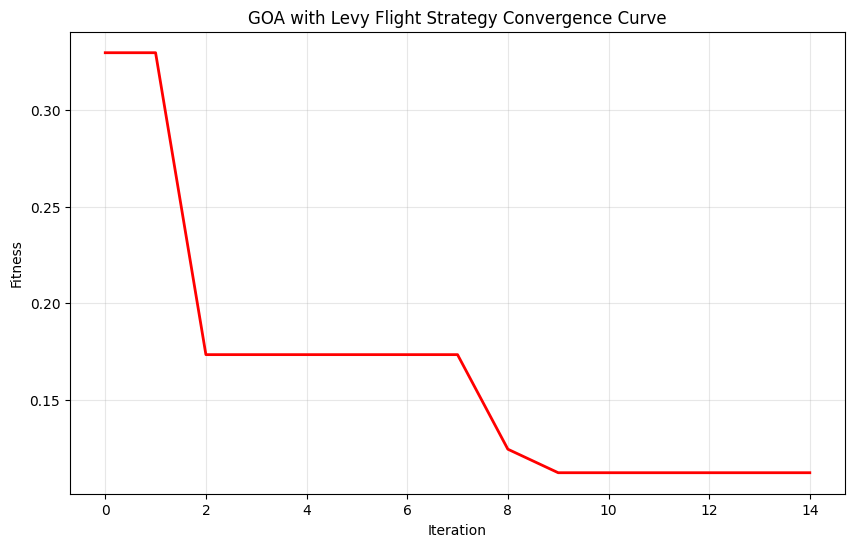

Levy Flight GOA Test Accuracy: 0.9306


In [ ]:
# Levy Flight GOA
result_levy, test_acc_levy = run_levy_goa_training(
    train_loader, valid_loader, test_loader, len(class_names)
)

# # Custom Levy Flight parameters
# result_custom, test_acc_custom = run_levy_goa_training(
#     train_loader, valid_loader, test_loader, len(class_names),
#     levy_beta=2.0,        # Higher beta for different Levy characteristics
#     delta=0.05,           # Larger steps
#     levy_probability=0.5  # More frequent Levy flights
# )

print(f"Levy Flight GOA Test Accuracy: {test_acc_levy:.4f}")

#### Another Levy Training

In [ ]:
def run_levy_goa_training(train_loader, valid_loader, test_loader, num_classes,
                         levy_beta=1.5, delta=0.01, levy_probability=0.3):
    """Run training with Levy Flight GOA"""
    trainer = GOA_CNN_Trainer_v2(train_loader, valid_loader, test_loader, num_classes)

    result = trainer.run_optimization_levy(
        population_size=8,
        max_iterations=15,
        levy_beta=levy_beta,
        delta=delta,
        levy_probability=levy_probability,
        verbose=True
    )

    test_accuracy = trainer.test_model(result['final_model'])

    plt.figure(figsize=(10, 6))
    plt.plot(result['convergence_history'], 'r-', linewidth=2)
    plt.title('GOA with Levy Flight Strategy Convergence Curve')
    plt.xlabel('Iteration')
    plt.ylabel('Fitness')
    plt.grid(True, alpha=0.3)
    plt.show()

    return result, test_accuracy

GOA with Levy Flight Strategy Optimization Started
Levy Parameters: β=1.8, δ=0.015, P=0.25
Initial Best Fitness: 0.451273
--------------------------------------------------
Iteration  10: Best Fitness = 0.243005
Final Best Fitness: 0.172378

Training final model with best parameters...
Best parameters: {'learning_rate': np.float64(0.00024405788669642893), 'hidden_units': 128, 'dropout_rate': np.float64(0.14091961437928924), 'weight_decay': np.float64(1.0408923116921208e-06)}
Test Accuracy: 0.9028


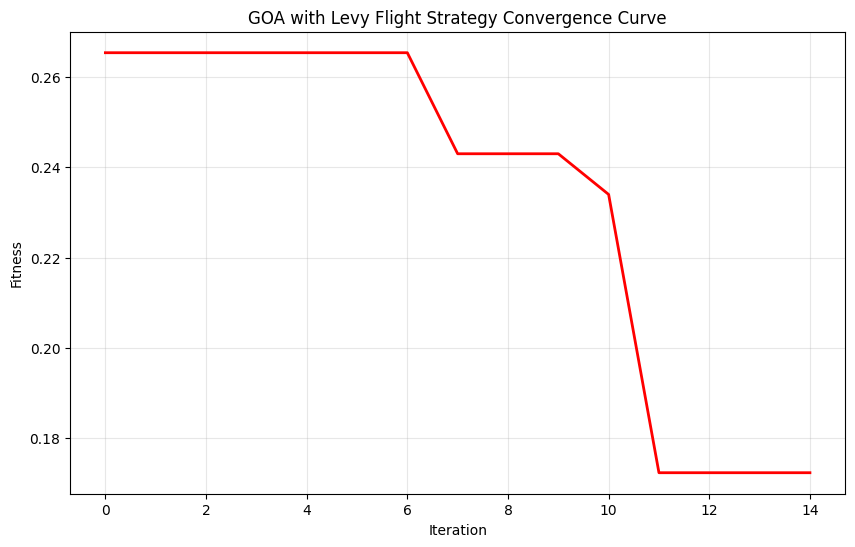

In [ ]:
result2, test_acc2 = run_levy_goa_training(
    train_loader, valid_loader, test_loader, len(class_names),
    levy_beta=1.8,
    delta=0.015,
    levy_probability=0.25
)

#### Roulette Strategy - Training

In [ ]:
def run_roulette_goa_training(train_loader, valid_loader, test_loader, num_classes,
                             selection_pressure=2.0, elite_ratio=0.1):
    """Run training with Roulette Wheel GOA"""
    trainer = GOA_CNN_Trainer_v2(train_loader, valid_loader, test_loader, num_classes)

    result = trainer.run_optimization_roulette(
        population_size=8,
        max_iterations=15,
        selection_pressure=selection_pressure,
        elite_ratio=elite_ratio,
        verbose=True
    )

    test_accuracy = trainer.test_model(result['final_model'])

    plt.figure(figsize=(10, 6))
    plt.plot(result['convergence_history'], 'g-', linewidth=2)
    plt.title('GOA with Roulette Wheel Selection Convergence Curve')
    plt.xlabel('Iteration')
    plt.ylabel('Fitness')
    plt.grid(True, alpha=0.3)
    plt.show()

    return result, test_accuracy

GOA with Roulette Wheel Selection Strategy Optimization Started
Selection Parameters: pressure=2.0, elite_ratio=0.1
Initial Best Fitness: 0.697719
--------------------------------------------------
Iteration  10: Best Fitness = 0.131756, Avg Prob = 0.1250
Final Best Fitness: 0.131756

Training final model with best parameters...
Best parameters: {'learning_rate': np.float64(0.0003236770371625551), 'hidden_units': 128, 'dropout_rate': np.float64(0.624664704769947), 'weight_decay': np.float64(3.915788590059044e-06)}
Test Accuracy: 0.8889


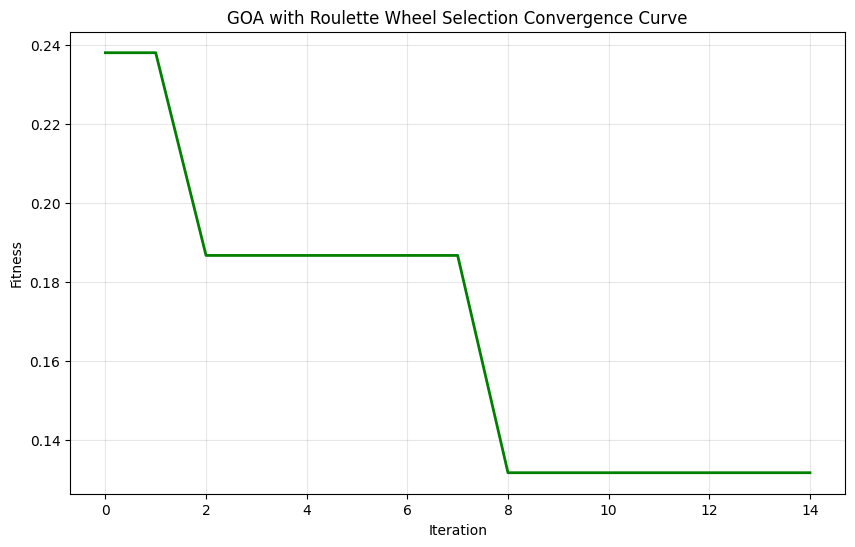

In [ ]:
# Roulette Wheel GOA
result_roulette, test_acc_roulette = run_roulette_goa_training(
    train_loader, valid_loader, test_loader, len(class_names)
)

# # Custom parameters
# result_custom, test_acc_custom = run_roulette_goa_training(
#     train_loader, valid_loader, test_loader, len(class_names),
#     selection_pressure=3.0,  # More selective (emphasizes fitness differences)
#     elite_ratio=0.2          # 20% of population considered elite
# )

#### Random Walk - Training

In [ ]:
def run_random_walk_goa_training(train_loader, valid_loader, test_loader, num_classes,
                                gamma=0.1, walk_probability=0.4, adaptive_gamma=True, walk_type="uniform"):
    """Run training with Random Walk GOA"""
    trainer = GOA_CNN_Trainer_v2(train_loader, valid_loader, test_loader, num_classes)

    result = trainer.run_optimization_random_walk(
        population_size=8,
        max_iterations=15,
        gamma=gamma,
        walk_probability=walk_probability,
        adaptive_gamma=adaptive_gamma,
        walk_type=walk_type,
        verbose=True
    )

    test_accuracy = trainer.test_model(result['final_model'])

    # Plot convergence and diversity
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    # Convergence plot
    ax1.plot(result['convergence_history'], 'orange', linewidth=2)
    ax1.set_title('GOA with Random Walk Strategy - Convergence')
    ax1.set_xlabel('Iteration')
    ax1.set_ylabel('Fitness')
    ax1.grid(True, alpha=0.3)

    return result, test_accuracy

GOA with Random Walk Strategy Optimization Started
Walk Parameters: γ=0.1, probability=0.4, type=uniform
Adaptive γ: True
Initial Best Fitness: 0.945777
--------------------------------------------------
Iteration  10: Best Fitness = 0.331304, γ = 0.0580, Diversity = 0.6989
Final Best Fitness: 0.200236

Training final model with best parameters...
Best parameters: {'learning_rate': np.float64(0.0008831732786553819), 'hidden_units': 22, 'dropout_rate': np.float64(0.0), 'weight_decay': np.float64(1e-06)}
Test Accuracy: 0.8889


'\n# Random Walk GOA with default parameters\nresult_rw, test_acc_rw = run_random_walk_goa_training(\n    train_loader, valid_loader, test_loader, len(class_names)\n)\n\n# Custom Random Walk parameters\nresult_custom, test_acc_custom = run_random_walk_goa_training(\n    train_loader, valid_loader, test_loader, len(class_names),\n    gamma=0.2,                # Larger steps\n    walk_probability=0.6,     # More frequent random walks\n    adaptive_gamma=True,      # Adaptive scaling\n    walk_type="mixed"         # Mixed uniform/gaussian walks\n)\n\n# Compare different walk types\nresult_uniform, _ = run_random_walk_goa_training(\n    train_loader, valid_loader, test_loader, len(class_names), walk_type="uniform"\n)\nresult_gaussian, _ = run_random_walk_goa_training(\n    train_loader, valid_loader, test_loader, len(class_names), walk_type="gaussian"\n)\nresult_mixed, _ = run_random_walk_goa_training(\n    train_loader, valid_loader, test_loader, len(class_names), walk_type="mixed"\n)\n\n

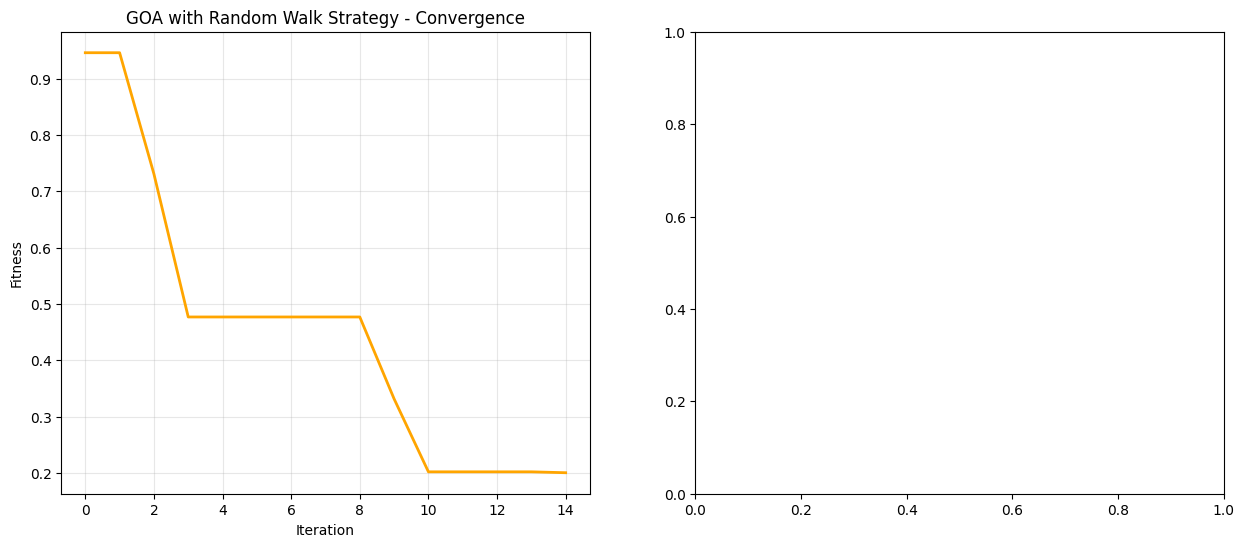

In [ ]:
result_rw, test_acc_rw = run_random_walk_goa_training(
    train_loader, valid_loader, test_loader, len(class_names)
)


"""
# Random Walk GOA with default parameters
result_rw, test_acc_rw = run_random_walk_goa_training(
    train_loader, valid_loader, test_loader, len(class_names)
)

# Custom Random Walk parameters
result_custom, test_acc_custom = run_random_walk_goa_training(
    train_loader, valid_loader, test_loader, len(class_names),
    gamma=0.2,                # Larger steps
    walk_probability=0.6,     # More frequent random walks
    adaptive_gamma=True,      # Adaptive scaling
    walk_type="mixed"         # Mixed uniform/gaussian walks
)

# Compare different walk types
result_uniform, _ = run_random_walk_goa_training(
    train_loader, valid_loader, test_loader, len(class_names), walk_type="uniform"
)
result_gaussian, _ = run_random_walk_goa_training(
    train_loader, valid_loader, test_loader, len(class_names), walk_type="gaussian"
)
result_mixed, _ = run_random_walk_goa_training(
    train_loader, valid_loader, test_loader, len(class_names), walk_type="mixed"
)

print(f"Standard GOA Test Accuracy: {test_acc_std:.4f}")
print(f"Random Walk GOA Test Accuracy: {test_acc_rw:.4f}")

# Compare convergence curves
plt.figure(figsize=(12, 6))
plt.plot(result_std['convergence_history'], 'b-', label='Standard GOA', linewidth=2)
plt.plot(result_rw['convergence_history'], 'orange', label='Random Walk GOA', linewidth=2)
plt.title('GOA Variants Comparison')
plt.xlabel('Iteration')
plt.ylabel('Fitness')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()
"""


#### Adaptive Strategy - Training

In [ ]:
def run_adaptive_goa_training(train_loader, valid_loader, test_loader, num_classes,
                             alpha_min=0.5, alpha_max=3.0, beta_min=0.1, beta_max=1.0,
                             diversity_threshold=0.1, stagnation_limit=5):
    """Run training with Adaptive GOA"""
    trainer = GOA_CNN_Trainer_v2(train_loader, valid_loader, test_loader, num_classes)

    result = trainer.run_optimization_adaptive(
        population_size=8,
        max_iterations=15,
        alpha_min=alpha_min,
        alpha_max=alpha_max,
        beta_min=beta_min,
        beta_max=beta_max,
        diversity_threshold=diversity_threshold,
        stagnation_limit=stagnation_limit,
        verbose=True
    )

    test_accuracy = trainer.test_model(result['final_model'])

    return result, test_accuracy

def plot_graph(result, alpha_min=0.5, alpha_max=3.0, beta_min=0.1, beta_max=1.0, diversity_threshold=0.1):
  # Enhanced plotting for adaptive strategy
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

    # Convergence curve
    ax1.plot(result['convergence_history'], 'b-', linewidth=2)
    ax1.set_title('GOA with Adaptive Strategy - Convergence Curve')
    ax1.set_xlabel('Iteration')
    ax1.set_ylabel('Fitness')
    ax1.grid(True, alpha=0.3)

    # Alpha adaptation
    ax2.plot(result['alpha_history'], 'r-', linewidth=2, label='α(t)')
    ax2.axhline(y=alpha_min, color='r', linestyle='--', alpha=0.5, label='α_min')
    ax2.axhline(y=alpha_max, color='r', linestyle='--', alpha=0.5, label='α_max')
    ax2.set_title('Acceleration Coefficient Adaptation')
    ax2.set_xlabel('Iteration')
    ax2.set_ylabel('α(t)')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    # Beta adaptation
    ax3.plot(result['beta_history'], 'g-', linewidth=2, label='β(t)')
    ax3.axhline(y=beta_min, color='g', linestyle='--', alpha=0.5, label='β_min')
    ax3.axhline(y=beta_max, color='g', linestyle='--', alpha=0.5, label='β_max')
    ax3.set_title('Random Motion Coefficient Adaptation')
    ax3.set_xlabel('Iteration')
    ax3.set_ylabel('β(t)')
    ax3.legend()
    ax3.grid(True, alpha=0.3)

    # Population diversity
    ax4.plot(result['diversity_history'], 'm-', linewidth=2, label='Diversity')
    ax4.axhline(y=diversity_threshold, color='m', linestyle='--', alpha=0.5, label='Threshold')
    ax4.set_title('Population Diversity Evolution')
    ax4.set_xlabel('Iteration')
    ax4.set_ylabel('Diversity')
    ax4.legend()
    ax4.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

In [ ]:
print("Running Adaptive GOA Training...")
result_adaptive, test_acc_adaptive = run_adaptive_goa_training(
    train_loader, valid_loader, test_loader, len(class_names)
)

Running Adaptive GOA Training...
GOA with Adaptive Strategy Optimization Started
Adaptive Parameters: α∈[0.5, 3.0], β∈[0.1, 1.0]
Diversity Threshold: 0.100, Stagnation Limit: 5
Initial Best Fitness: 0.240416
----------------------------------------------------------------------
Iter   5: Fitness=0.101650 | α(t)=2.821 | β(t)=0.873 | Div=0.236 | Stag=0
Iter  10: Fitness=0.101650 | α(t)=2.677 | β(t)=0.823 | Div=0.263 | Stag=4
Iter  15: Fitness=0.101650 | α(t)=2.810 | β(t)=0.883 | Div=0.261 | Stag=9
Final Best Fitness: 0.101650
Final α(t): 2.810, Final β(t): 0.883
Average Diversity: 0.293

Training final model with best parameters...
Best parameters: {'learning_rate': np.float64(0.00039818874721858237), 'hidden_units': 128, 'dropout_rate': np.float64(0.0), 'weight_decay': np.float64(1e-06)}
Test Accuracy: 0.8472


KeyError: 'alpha_history'

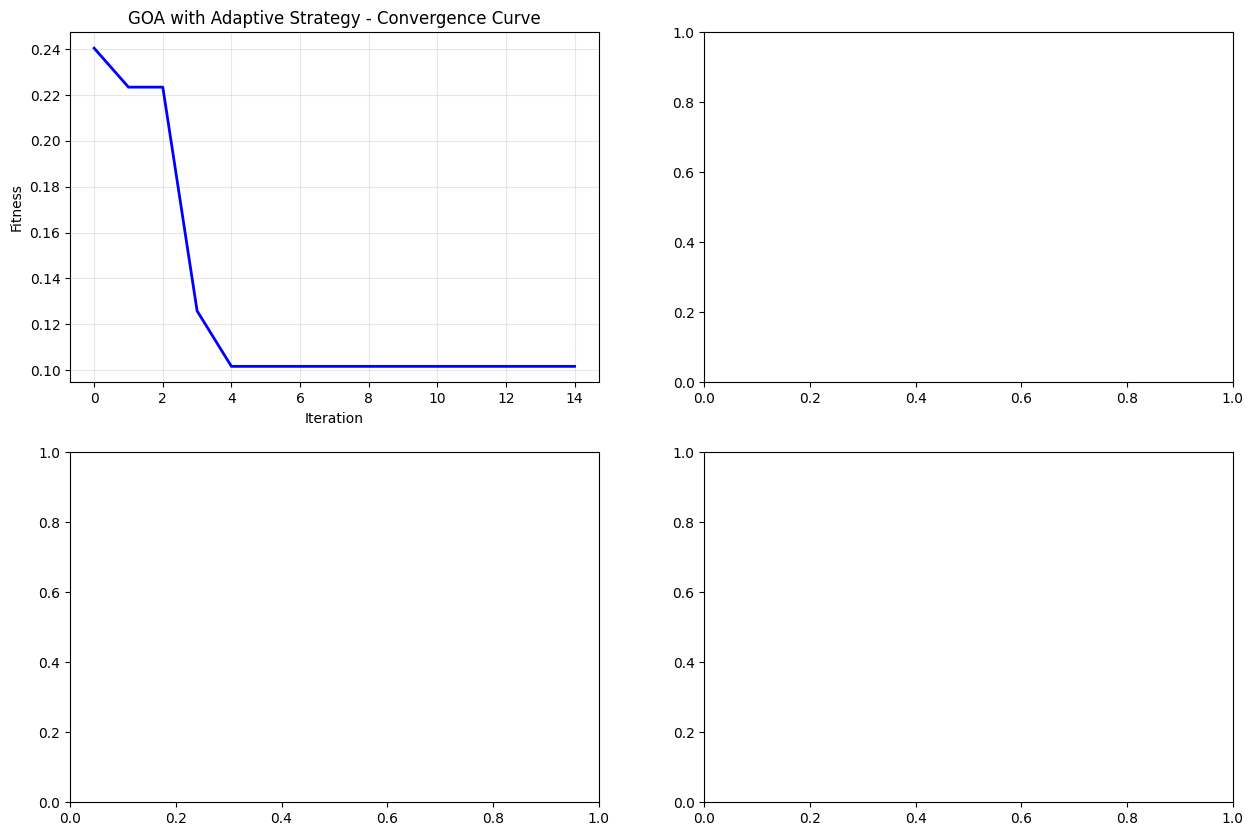

In [ ]:
plot_graph(result_adaptive)

#### Fractual

In [ ]:
def run_fractal_goa_training(train_loader, valid_loader, test_loader, num_classes,
                           base_step=0.05, fractal_exponent=1.0, mapping_type="explorative"):
    """Run training with Fractal Dimension GOA"""
    trainer = GOA_CNN_Trainer_v2(train_loader, valid_loader, test_loader, num_classes)

    result = trainer.run_optimization_fractal(
        population_size=8,
        max_iterations=15,
        base_step=base_step,
        fractal_exponent=fractal_exponent,
        mapping_type=mapping_type,
        verbose=True
    )

    test_accuracy = trainer.test_model(result['final_model'])

    # Convergence curve only
    plt.figure(figsize=(10, 6))
    plt.plot(result['convergence_history'], 'purple', linewidth=2)
    plt.title('GOA with Fractal Dimension Strategy - Convergence')
    plt.xlabel('Iteration')
    plt.ylabel('Fitness')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    # Print fractal analysis
    print(f"\nFractal Dimension Analysis:")
    print(f"Average D_f: {np.mean(result['D_f_history']):.3f}")
    print(f"Final D_f: {result['final_D_f']:.3f}")
    print(f"D_f Range: [{np.min(result['D_f_history']):.3f}, {np.max(result['D_f_history']):.3f}]")
    print(f"Final Step Size: {result['final_step_size']:.4f}")

    return result, test_accuracy


# Advanced usage with parameter exploration
def explore_fractal_parameters():
    """Explore different fractal dimension parameters"""
    configurations = [
        # (mapping_type, base_step, fractal_exponent, description)
        ("explorative", 0.03, 0.8, "Conservative Explorative"),
        ("explorative", 0.05, 1.0, "Standard Explorative"),
        ("explorative", 0.07, 1.2, "Aggressive Explorative"),
        ("exploitative", 0.03, 0.8, "Conservative Exploitative"),
        ("exploitative", 0.05, 1.0, "Standard Exploitative"),
    ]

    results = {}

    for mapping, base_step, exp, desc in configurations:
        print(f"\nTesting {desc} (mapping={mapping}, step={base_step}, exp={exp})")

        result, test_acc = run_fractal_goa_training(
            train_loader, valid_loader, test_loader, len(class_names),
            base_step=base_step,
            fractal_exponent=exp,
            mapping_type=mapping
        )

        results[desc] = {
            'result': result,
            'test_accuracy': test_acc,
            'config': (mapping, base_step, exp)
        }

        print(f"Test Accuracy: {test_acc:.4f}")

    # Summary comparison
    print(f"\n{'='*60}")
    print("FRACTAL DIMENSION GOA PARAMETER EXPLORATION SUMMARY")
    print(f"{'='*60}")

    for desc, data in results.items():
        acc = data['test_accuracy']
        final_df = data['result']['final_D_f']
        avg_df = np.mean(data['result']['D_f_history'])
        print(f"{desc:25s}: Acc={acc:.4f}, Final_Df={final_df:.3f}, Avg_Df={avg_df:.3f}")

    return results

In [ ]:
print("Running Fractal Dimension GOA Training...")
result_fractal, test_acc_fractal = run_fractal_goa_training(
    train_loader, valid_loader, test_loader, len(class_names)
)

#### Predator Aware - Training

In [ ]:
def run_predator_aware_goa_training(train_loader, valid_loader, test_loader, num_classes,
                                   alpha=1.5, beta=0.2, w=0.8, gamma=2.0, sigma=0.5, S=8):
    """Run training with Predator-Aware Momentum GOA"""
    trainer = GOA_CNN_Trainer_v2(train_loader, valid_loader, test_loader, num_classes)

    result = trainer.run_optimization_predator_aware(
        population_size=8,
        max_iterations=15,
        alpha=alpha,
        beta=beta,
        w=w,
        gamma=gamma,
        sigma=sigma,
        S=S,
        verbose=True
    )

    test_accuracy = trainer.test_model(result['final_model'])

    return result, test_accuracy

In [ ]:
def plot_graph(result, alpha=1.5, beta=0.2, w=0.8, gamma=2.0, sigma=0.5, S=8):
    # Convergence curve only
    plt.figure(figsize=(10, 6))
    plt.plot(result['convergence_history'], 'darkred', linewidth=2, label='Fitness')

    # # Mark escape events
    # for event_iter in result['escape_events']:
    #     if event_iter < len(result['convergence_history']):
    #         plt.axvline(x=event_iter, color='orange', linestyle='--', alpha=0.7)

    plt.title('PAM-GOA Convergence ')
    plt.xlabel('Iteration')
    plt.ylabel('Fitness')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    # Print predator analysis
    print(f"\nPredator-Aware Momentum Analysis:")
    print(f"Total Escape Events: {result['total_escape_events']}")
    print(f"Final Predator Intensity: {result['final_predator_intensity']:.3f}")
    print(f"Final Stagnation Period: {result['final_stagnation']} iterations")
    print(f"Average Predator Intensity: {np.mean(result['P_history']):.3f}")
    print(f"Max Burst Magnitude: {np.max(result['burst_magnitude_history']):.3f}")

In [ ]:
print("Running Predator-Aware Momentum GOA Training...")
result_pred_aware, test_acc_pred_aware = run_predator_aware_goa_training(
    train_loader, valid_loader, test_loader, len(class_names)
)

Running Predator-Aware Momentum GOA Training...
GOA with Predator-Aware Momentum Strategy Optimization Started
Parameters: w=0.8, α=1.5, β=0.2, γ=2.0
Stagnation threshold S=8, burst σ=0.5, vmax=0.3
Initial Best Fitness: 0.274778
---------------------------------------------------------------------------
Iter   5: Fitness=0.121634 | P(t)=0.000 | Stag=0 | AvgVel=0.400 | Bursts=3
Iter  10: Fitness=0.104861 | P(t)=0.000 | Stag=0 | AvgVel=0.449 | Bursts=4
Iter  15: Fitness=0.104861 | P(t)=0.625 | Stag=5 | AvgVel=0.552 | Bursts=5
Final Best Fitness: 0.104861
Final Predator Intensity: 0.625
Total Escape Events: 12
Final Stagnation: 5 iterations

Training final model with best parameters...
Best parameters: {'learning_rate': np.float64(0.0002994933304981124), 'hidden_units': 128, 'dropout_rate': np.float64(0.42395716435233205), 'weight_decay': np.float64(1e-06)}
Test Accuracy: 0.9167


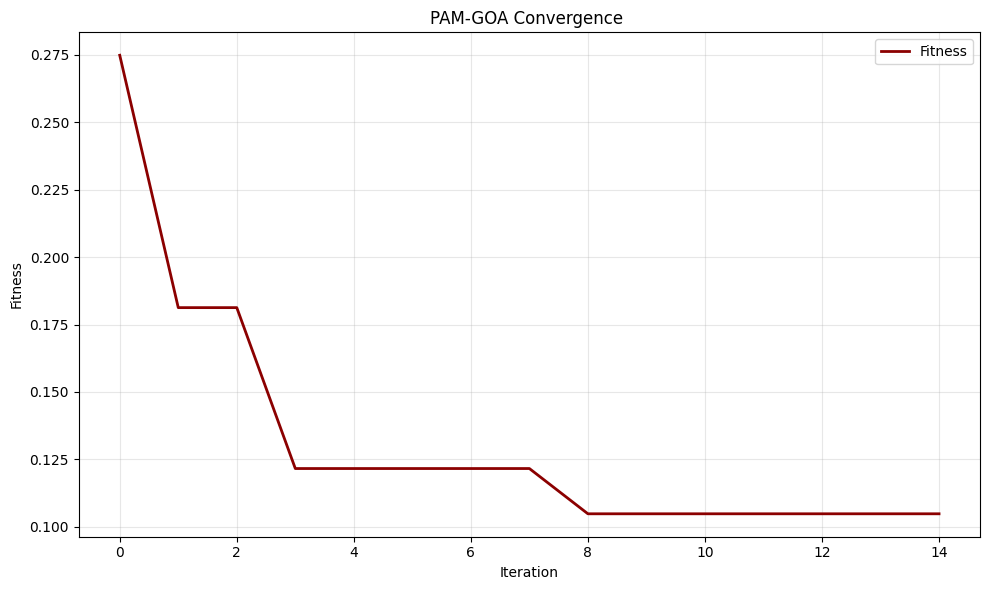


Predator-Aware Momentum Analysis:


KeyError: 'total_escape_events'

In [ ]:
plot_graph(result_pred_aware)

### Multi-stage Predator Aware Training

In [ ]:

def run_adaptive_predator_training(train_loader, valid_loader, test_loader, num_classes):
    """
    Method 1: Adaptive Predator Intensity with Multi-Stage Training

    This method dynamically adjusts predator parameters based on training progress
    and uses multi-stage optimization with different parameter regimes.
    """
    trainer = GOA_CNN_Trainer_v2(train_loader, valid_loader, test_loader, num_classes)

    print("=== Adaptive Predator Training Strategy ===")

    # Stage 1: High exploration with sensitive predator response
    print("\nStage 1: High Exploration Phase")
    result_stage1 = trainer.run_optimization_predator_aware(
        population_size=12,          # Larger population for better exploration
        max_iterations=15,
        alpha=2.2,                   # Higher attraction to best
        beta=0.35,                   # Increased random exploration
        w=0.75,                      # Lower inertia for more responsiveness
        gamma=3.5,                   # Strong predator bursts
        sigma=0.7,                   # Higher burst variance
        S=5,                         # Sensitive to stagnation (quick response)
        vmax=0.4,                    # Higher velocity limits
        verbose=True
    )

    # # Stage 2: Balanced exploration-exploitation
    # print("\nStage 2: Balanced Phase")
    # # Use best position from stage 1 as starting elite
    # result_stage2 = trainer.run_optimization_predator_aware(
    #     population_size=10,
    #     max_iterations=15,
    #     alpha=1.8,                   # Moderate attraction
    #     beta=0.25,                   # Reduced random exploration
    #     w=0.85,                      # Higher inertia for stability
    #     gamma=2.5,                   # Moderate bursts
    #     sigma=0.5,                   # Standard burst variance
    #     S=8,                         # Standard stagnation threshold
    #     vmax=0.3,                    # Standard velocity
    #     verbose=True
    # )

    # # Stage 3: Fine-tuning with conservative predator response
    # print("\nStage 3: Fine-tuning Phase")
    # result_stage3 = trainer.run_optimization_predator_aware(
    #     population_size=8,
    #     max_iterations=15,
    #     alpha=1.2,                   # Lower attraction for fine-tuning
    #     beta=0.15,                   # Minimal random exploration
    #     w=0.9,                       # High inertia for convergence
    #     gamma=1.8,                   # Gentler bursts
    #     sigma=0.35,                  # Lower burst variance
    #     S=12,                        # Less sensitive to stagnation
    #     vmax=0.2,                    # Lower velocity for precision
    #     verbose=True
    # )

    # Select best result across all stages
    best_result = min([result_stage1],
                     key=lambda x: x['convergence_history'][-1])

    test_accuracy = trainer.test_model(best_result['final_model'])

    print(f"\n=== Multi-Stage Results ===")
    print(f"Stage 1 Final Fitness: {result_stage1['convergence_history'][-1]:.6f}")
    # print(f"Stage 2 Final Fitness: {result_stage2['convergence_history'][-1]:.6f}")
    # print(f"Stage 3 Final Fitness: {result_stage3['convergence_history'][-1]:.6f}")
    print(f"Best Stage Test Accuracy: {test_accuracy:.4f}")

    return best_result, test_accuracy

In [ ]:
# Method 1: Adaptive Multi-Stage Training
print("Method 1: Running Adaptive Predator Training...")
result1, acc1 = run_adaptive_predator_training(train_loader, valid_loader, test_loader, len(class_names))
print(f"Adaptive Training Final Accuracy: {acc1:.4f}\n")

Method 1: Running Adaptive Predator Training...
=== Adaptive Predator Training Strategy ===

Stage 1: High Exploration Phase
GOA with Predator-Aware Momentum Strategy Optimization Started
Parameters: w=0.75, α=2.2, β=0.35, γ=3.5
Stagnation threshold S=5, burst σ=0.7, vmax=0.4
Initial Best Fitness: 0.232424
---------------------------------------------------------------------------
Iter   5: Fitness=0.128374 | P(t)=0.000 | Stag=0 | AvgVel=0.685 | Bursts=4
Iter  10: Fitness=0.128374 | P(t)=0.800 | Stag=4 | AvgVel=0.689 | Bursts=4
Iter  15: Fitness=0.101210 | P(t)=0.000 | Stag=0 | AvgVel=0.686 | Bursts=4
Final Best Fitness: 0.101210
Final Predator Intensity: 0.000
Total Escape Events: 12
Final Stagnation: 0 iterations

Training final model with best parameters...
Best parameters: {'learning_rate': np.float64(0.0004836470394175943), 'hidden_units': 75, 'dropout_rate': np.float64(0.20520480946682212), 'weight_decay': np.float64(1e-06)}
Test Accuracy: 0.8611

=== Multi-Stage Results ===
Stag

## HYPERPARAMETER TUNING

In [ ]:
class RandomSearchMixin:
    """Mixin class to add random search capabilities to any trainer"""

    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.search_history = []
        self.best_config = None
        self.best_score = float('inf')

    def sample_hyperparameters(self, param_distributions: Dict[str, Any], n_samples: int = 1) -> List[Dict[str, Any]]:
        """
        Sample hyperparameters from given distributions

        Args:
            param_distributions: Dictionary of parameter distributions
            n_samples: Number of samples to generate

        Returns:
            List of sampled parameter configurations
        """
        sampler = ParameterSampler(param_distributions, n_iter=n_samples, random_state=42)
        return list(sampler)

    def evaluate_config(self, config: Dict[str, Any], **kwargs) -> Dict[str, Any]:
        """
        Evaluate a single hyperparameter configuration
        Must be implemented by child classes
        """
        raise NotImplementedError("Child classes must implement evaluate_config")

    def random_search(self,
                     param_distributions: Dict[str, Any],
                     n_trials: int = 20,
                     scoring: str = 'validation_loss',
                     minimize: bool = True,
                     save_results: bool = True,
                     verbose: bool = True) -> Dict[str, Any]:
        """
        Perform random search over hyperparameters

        Args:
            param_distributions: Parameter distributions to sample from
            n_trials: Number of trials to run
            scoring: Metric to optimize
            minimize: Whether to minimize the scoring metric
            save_results: Whether to save results to file
            verbose: Whether to print progress

        Returns:
            Dictionary containing best configuration and all results
        """
        if verbose:
            print(f"Starting Random Search with {n_trials} trials...")
            print(f"Optimizing: {'minimize' if minimize else 'maximize'} {scoring}")
            print("=" * 60)

        # Sample all configurations at once
        configs = self.sample_hyperparameters(param_distributions, n_trials)

        results = []

        for trial_idx, config in enumerate(configs):
            if verbose:
                print(f"\nTrial {trial_idx + 1}/{n_trials}")
                print(f"Config: {config}")

            try:
                # Evaluate the configuration
                result = self.evaluate_config(config, trial_idx=trial_idx, verbose=verbose)

                # Extract score
                score = result.get(scoring, float('inf'))
                result['trial'] = trial_idx + 1
                result['config'] = config
                result['score'] = score

                results.append(result)
                self.search_history.append(result)

                # Update best configuration
                is_better = (score < self.best_score) if minimize else (score > self.best_score)
                if is_better:
                    self.best_score = score
                    self.best_config = config.copy()
                    if verbose:
                        print(f"🎯 New best {scoring}: {score:.6f}")

                if verbose:
                    print(f"Current {scoring}: {score:.6f}")
                    print(f"Best so far: {self.best_score:.6f}")

            except Exception as e:
                if verbose:
                    print(f"❌ Trial failed: {str(e)}")
                continue

        # Compile final results
        final_results = {
            'best_config': self.best_config,
            'best_score': self.best_score,
            'best_scoring_metric': scoring,
            'all_results': results,
            'n_trials': len(results),
            'search_space': param_distributions
        }

        if save_results:
            self.save_search_results(final_results)

        if verbose:
            print("\n" + "=" * 60)
            print("🏆 Random Search Complete!")
            print(f"Best {scoring}: {self.best_score:.6f}")
            print(f"Best config: {self.best_config}")
            print(f"Successful trials: {len(results)}/{n_trials}")

        return final_results

    def save_search_results(self, results: Dict[str, Any], filename: Optional[str] = None):
        """Save search results to JSON file"""
        if filename is None:
            timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
            filename = f"random_search_results_{timestamp}.json"

        # Convert numpy types to Python types for JSON serialization
        def convert_types(obj):
            if isinstance(obj, np.integer):
                return int(obj)
            elif isinstance(obj, np.floating):
                return float(obj)
            elif isinstance(obj, np.ndarray):
                return obj.tolist()
            elif isinstance(obj, dict):
                return {key: convert_types(value) for key, value in obj.items()}
            elif isinstance(obj, list):
                return [convert_types(item) for item in obj]
            return obj

        serializable_results = convert_types(results)

        with open(filename, 'w') as f:
            json.dump(serializable_results, f, indent=2)
        print(f"📁 Results saved to {filename}")

    def plot_search_progress(self, scoring_metric: str = 'validation_loss', figsize: Tuple[int, int] = (12, 8)):
        """Plot random search progress"""
        if not self.search_history:
            print("No search history to plot")
            return

        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=figsize)

        # Extract data
        trials = [r['trial'] for r in self.search_history]
        scores = [r.get(scoring_metric, float('inf')) for r in self.search_history]

        # 1. Score progression
        ax1.plot(trials, scores, 'o-', alpha=0.7, label='Trial scores')
        best_scores = []
        current_best = float('inf') if 'loss' in scoring_metric.lower() else float('-inf')

        for score in scores:
            if ('loss' in scoring_metric.lower() and score < current_best) or \
               ('accuracy' in scoring_metric.lower() and score > current_best):
                current_best = score
            best_scores.append(current_best)

        ax1.plot(trials, best_scores, 'r-', linewidth=2, label='Best so far')
        ax1.set_xlabel('Trial')
        ax1.set_ylabel(scoring_metric)
        ax1.set_title('Search Progress')
        ax1.legend()
        ax1.grid(True, alpha=0.3)

        # 2. Score distribution
        ax2.hist(scores, bins=min(20, len(scores)//2 + 1), alpha=0.7, edgecolor='black')
        ax2.axvline(self.best_score, color='red', linestyle='--', linewidth=2, label=f'Best: {self.best_score:.4f}')
        ax2.set_xlabel(scoring_metric)
        ax2.set_ylabel('Frequency')
        ax2.set_title('Score Distribution')
        ax2.legend()
        ax2.grid(True, alpha=0.3)

        # 3. Parameter correlation (if available)
        if len(self.search_history) > 1:
            # Get a sample parameter for correlation analysis
            sample_config = self.search_history[0]['config']
            if sample_config:
                param_name = list(sample_config.keys())[0]
                param_values = [r['config'].get(param_name, 0) for r in self.search_history]
                ax3.scatter(param_values, scores, alpha=0.7)
                ax3.set_xlabel(param_name)
                ax3.set_ylabel(scoring_metric)
                ax3.set_title(f'{param_name} vs {scoring_metric}')
                ax3.grid(True, alpha=0.3)

        # 4. Top configurations
        sorted_results = sorted(self.search_history,
                              key=lambda x: x.get(scoring_metric, float('inf')))
        top_5 = sorted_results[:5]

        top_trials = [r['trial'] for r in top_5]
        top_scores = [r.get(scoring_metric, float('inf')) for r in top_5]

        ax4.bar(range(len(top_5)), top_scores, alpha=0.7)
        ax4.set_xlabel('Top Configurations')
        ax4.set_ylabel(scoring_metric)
        ax4.set_title('Top 5 Configurations')
        ax4.set_xticks(range(len(top_5)))
        ax4.set_xticklabels([f"Trial {t}" for t in top_trials], rotation=45)
        ax4.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

In [ ]:
class RandomSearchGOATrainer(GOA_CNN_Trainer_v2, RandomSearchMixin):
    """
    Enhanced GOA CNN Trainer with Random Search capabilities
    Inherits from both GOA_CNN_Trainer_v2 and RandomSearchMixin
    """

    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

        # Store current GOA variant for evaluate_config
        self.current_goa_variant = 'predator_aware'

        # Define default search spaces for different GOA variants
        self.default_search_spaces = {
            'predator_aware': {
                'alpha': uniform(0.5, 2.5),      # 0.5 to 3.0
                'beta': uniform(0.1, 0.9),       # 0.1 to 1.0
                'w': uniform(0.5, 0.9),          # inertia weight 0.5 to 1.4
                'gamma': uniform(1.0, 3.0),      # predator burst 1.0 to 4.0
                'sigma': uniform(0.1, 1.0),      # burst noise 0.1 to 1.1
                'S': randint(5, 15),             # stagnation threshold 5 to 14
                'vmax': uniform(0.1, 0.5),       # max velocity 0.1 to 0.6
                'population_size': randint(8, 20), # population 8 to 19
                'max_iterations': randint(10, 25)  # iterations 10 to 24
            },
            'standard': {
                'alpha': uniform(1.0, 2.0),      # 1.0 to 3.0
                'beta': uniform(0.2, 0.8),       # 0.2 to 1.0
                'population_size': randint(8, 20),
                'max_iterations': randint(10, 25)
            },
            'adaptive': {
                'alpha_min': uniform(0.3, 0.7),  # 0.3 to 1.0
                'alpha_max': uniform(2.0, 1.0),  # 2.0 to 3.0
                'beta_min': uniform(0.05, 0.15), # 0.05 to 0.2
                'beta_max': uniform(0.8, 0.2),   # 0.8 to 1.0
                'diversity_threshold': uniform(0.05, 0.15),
                'stagnation_limit': randint(3, 8),
                'adaptation_rate': uniform(0.05, 0.15),
                'population_size': randint(8, 20),
                'max_iterations': randint(10, 25)
            }
        }

    def evaluate_config(self, config: Dict[str, Any], **kwargs) -> Dict[str, Any]:
        """
        Evaluate a single hyperparameter configuration for GOA training
        """
        trial_idx = kwargs.get('trial_idx', 0)
        verbose = kwargs.get('verbose', True)
        goa_variant = kwargs.get('goa_variant', self.current_goa_variant)

        if verbose:
            print(f"  Training with {goa_variant} GOA...")

        try:
            # Choose the appropriate GOA variant based on configuration
            if goa_variant == 'predator_aware':
                result = self.run_optimization_predator_aware(
                    population_size=config.get('population_size', 10),
                    max_iterations=config.get('max_iterations', 15),
                    alpha=config.get('alpha', 1.5),
                    beta=config.get('beta', 0.2),
                    w=config.get('w', 0.8),
                    gamma=config.get('gamma', 2.0),
                    sigma=config.get('sigma', 0.5),
                    S=config.get('S', 8),
                    vmax=config.get('vmax', 0.3),
                    verbose=False  # Suppress GOA verbose output
                )
            elif goa_variant == 'standard':
                result = self.run_optimization_standard(
                    population_size=config.get('population_size', 10),
                    max_iterations=config.get('max_iterations', 20),
                    verbose=False
                )
            elif goa_variant == 'adaptive':
                result = self.run_optimization_adaptive(
                    population_size=config.get('population_size', 10),
                    max_iterations=config.get('max_iterations', 20),
                    alpha_min=config.get('alpha_min', 0.5),
                    alpha_max=config.get('alpha_max', 3.0),
                    beta_min=config.get('beta_min', 0.1),
                    beta_max=config.get('beta_max', 1.0),
                    diversity_threshold=config.get('diversity_threshold', 0.1),
                    stagnation_limit=config.get('stagnation_limit', 5),
                    adaptation_rate=config.get('adaptation_rate', 0.1),
                    verbose=False
                )
            else:
                raise ValueError(f"Unknown GOA variant: {goa_variant}")

            # Test the model
            test_accuracy = self.test_model(result['final_model'])

            # Calculate validation loss (lower is better)
            validation_loss = 1.0 - result['final_accuracy']

            return {
                'validation_loss': validation_loss,
                'validation_accuracy': result['final_accuracy'],
                'test_accuracy': test_accuracy,
                'best_params': result['best_params'],
                'convergence_history': result['convergence_history'],
                'final_model': result['final_model']
            }

        except Exception as e:
            if verbose:
                print(f"    Error in evaluation: {str(e)}")
            # Return poor performance for failed trials
            return {
                'validation_loss': 1.0,
                'validation_accuracy': 0.0,
                'test_accuracy': 0.0,
                'error': str(e)
            }

    def search_predator_aware_goa(self, n_trials: int = 20, **search_kwargs) -> Dict[str, Any]:
        """Perform random search specifically for Predator-Aware Momentum GOA"""
        self.current_goa_variant = 'predator_aware'
        return self.random_search(
            param_distributions=self.default_search_spaces['predator_aware'],
            n_trials=n_trials,
            **search_kwargs
        )

    def search_standard_goa(self, n_trials: int = 20, **search_kwargs) -> Dict[str, Any]:
        """Perform random search for standard GOA"""
        self.current_goa_variant = 'standard'
        return self.random_search(
            param_distributions=self.default_search_spaces['standard'],
            n_trials=n_trials,
            **search_kwargs
        )

    def search_adaptive_goa(self, n_trials: int = 20, **search_kwargs) -> Dict[str, Any]:
        """Perform random search for adaptive GOA"""
        self.current_goa_variant = 'adaptive'
        return self.random_search(
            param_distributions=self.default_search_spaces['adaptive'],
            n_trials=n_trials,
            **search_kwargs
        )

    def custom_search_space(self, custom_distributions: Dict[str, Any],
                           goa_variant: str = 'predator_aware',
                           n_trials: int = 20, **search_kwargs) -> Dict[str, Any]:
        """Perform random search with custom parameter distributions"""
        self.current_goa_variant = goa_variant
        return self.random_search(
            param_distributions=custom_distributions,
            n_trials=n_trials,
            **search_kwargs
        )

    def compare_goa_variants(self, n_trials_per_variant: int = 10) -> Dict[str, Any]:
        """Compare different GOA variants using random search"""
        print("🔬 Comparing GOA Variants with Random Search...")
        print("=" * 60)

        variants = ['predator_aware', 'standard', 'adaptive']
        results = {}

        for variant in variants:
            print(f"\n🧪 Testing {variant.upper()} GOA...")

            if variant == 'predator_aware':
                variant_result = self.search_predator_aware_goa(
                    n_trials=n_trials_per_variant, verbose=True
                )
            elif variant == 'standard':
                variant_result = self.search_standard_goa(
                    n_trials=n_trials_per_variant, verbose=True
                )
            elif variant == 'adaptive':
                variant_result = self.search_adaptive_goa(
                    n_trials=n_trials_per_variant, verbose=True
                )

            results[variant] = variant_result

        # Summary comparison
        print("\n" + "=" * 60)
        print("📊 VARIANT COMPARISON SUMMARY")
        print("=" * 60)

        for variant, result in results.items():
            print(f"{variant.upper():>15}: Best Score = {result['best_score']:.6f}")

        # Find overall best
        best_variant = min(results.keys(), key=lambda x: results[x]['best_score'])
        print(f"\n🏆 WINNER: {best_variant.upper()} GOA")
        print(f"Best Overall Score: {results[best_variant]['best_score']:.6f}")

        return {
            'variant_results': results,
            'best_variant': best_variant,
            'best_overall_score': results[best_variant]['best_score'],
            'best_overall_config': results[best_variant]['best_config']
        }


#### Predator Aware Momentum - Hyperparameter Tuning

In [ ]:
def quick_predator_aware_search(train_loader, valid_loader, test_loader, num_classes,
                                n_trials: int = 20):
    """
    Quick start function for Predator-Aware GOA hyperparameter search
    """
    trainer = RandomSearchGOATrainer(train_loader, valid_loader, test_loader, num_classes)

    # Focused search space for metal detection - FIXED distributions
    focused_space = {
        'alpha': uniform(1.0, 1.0),      # uniform(loc, scale) so this is 1.0 to 2.0
        'beta': uniform(0.15, 0.25),     # 0.15 to 0.40
        'w': uniform(0.75, 0.15),        # 0.75 to 0.90
        'gamma': uniform(1.8, 1.2),      # 1.8 to 3.0
        'sigma': uniform(0.3, 0.5),      # 0.3 to 0.8
        'S': randint(6, 12),             # 6 to 11
        'vmax': uniform(0.2, 0.2),       # 0.2 to 0.4
        'population_size': [12, 16, 14, 18],  # Choice from these values
        'max_iterations': [18, 20, 22, 24]    # Choice from these values
    }

    return trainer.custom_search_space(
        custom_distributions=focused_space,
        goa_variant='predator_aware',
        n_trials=n_trials,
        scoring='validation_loss',
        minimize=True,
        verbose=True
    )

In [ ]:
print("Quick Focused Search")
print("=" * 60)

trainer = RandomSearchGOATrainer(
    train_loader=train_loader,
    valid_loader=valid_loader,
    test_loader=test_loader,
    num_classes=len(class_names)
)

# Run focused hyperparameter search
results = quick_predator_aware_search(
    train_loader, valid_loader, test_loader,
    len(class_names), n_trials=15
)

print(f"🏆 Best configuration found:")
print(f"Validation Loss: {results['best_score']:.6f}")
print(f"Best params: {results['best_config']}")

# Train final model with best configuration
print("\n📚 Training final model with best configuration...")
final_result = trainer.evaluate_config(
    results['best_config'],
    goa_variant='predator_aware',
    verbose=True
)

print(f"Final Test Accuracy: {final_result['test_accuracy']:.4f}")

Quick Focused Search
Starting Random Search with 15 trials...
Optimizing: minimize validation_loss

Trial 1/15
Config: {'S': 9, 'alpha': np.float64(1.9507143064099162), 'beta': np.float64(0.33299848545285127), 'gamma': np.float64(2.5183901810364437), 'max_iterations': 22, 'population_size': 16, 'sigma': np.float64(0.3779972601681013), 'vmax': np.float64(0.2116167224336399), 'w': np.float64(0.8799264218662403)}
  Training with predator_aware GOA...


In [ ]:
def get_training_accuracy(model, train_loader, device='cuda' if torch.cuda.is_available() else 'cpu'):
    """
    Evaluate the trained model on training data to get training accuracy

    Args:
        model: Your trained TinyVGG model
        train_loader: Your training data loader
        device: Device to run evaluation on

    Returns:
        training_accuracy: Accuracy on training set
    """
    model.eval()  # Set model to evaluation mode
    train_correct = 0
    train_total = 0

    print("Evaluating model on training data...")

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            output = model(data)
            pred = output.argmax(dim=1)
            train_correct += pred.eq(target).sum().item()
            train_total += target.size(0)

            # Print progress every 50 batches
            if (batch_idx + 1) % 50 == 0:
                current_acc = train_correct / train_total
                print(f"Batch {batch_idx + 1}: Current Training Accuracy = {current_acc:.4f}")

    training_accuracy = train_correct / train_total
    print(f"\nFinal Training Accuracy: {training_accuracy:.4f}")
    return training_accuracy

def get_validation_accuracy(model, valid_loader, device='cuda' if torch.cuda.is_available() else 'cpu'):
    """
    Evaluate the trained model on validation data to get validation accuracy

    Args:
        model: Your trained TinyVGG model
        valid_loader: Your validation data loader
        device: Device to run evaluation on

    Returns:
        validation_accuracy: Accuracy on validation set
    """
    model.eval()
    valid_correct = 0
    valid_total = 0

    print("Evaluating model on validation data...")

    with torch.no_grad():
        for data, target in valid_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            pred = output.argmax(dim=1)
            valid_correct += pred.eq(target).sum().item()
            valid_total += target.size(0)

    validation_accuracy = valid_correct / valid_total
    print(f"Validation Accuracy: {validation_accuracy:.4f}")
    return validation_accuracy

def get_all_accuracies(model, train_loader, valid_loader, test_loader, device='cuda' if torch.cuda.is_available() else 'cpu'):
    """
    Get training, validation, and test accuracies from your trained model

    Args:
        model: Your trained TinyVGG model
        train_loader: Training data loader
        valid_loader: Validation data loader
        test_loader: Test data loader
        device: Device to run evaluation on

    Returns:
        dict: Dictionary with all accuracies
    """
    print("="*60)
    print("EVALUATING TRAINED MODEL ON ALL DATASETS")
    print("="*60)

    # Get training accuracy
    train_acc = get_training_accuracy(model, train_loader, device)
    print("-" * 40)

    # Get validation accuracy
    valid_acc = get_validation_accuracy(model, valid_loader, device)
    print("-" * 40)

    # Get test accuracy (you already have this, but for completeness)
    model.eval()
    test_correct = 0
    test_total = 0

    print("Evaluating model on test data...")
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            pred = output.argmax(dim=1)
            test_correct += pred.eq(target).sum().item()
            test_total += target.size(0)

    test_acc = test_correct / test_total
    print(f"Test Accuracy: {test_acc:.4f}")

    print("="*60)
    print("SUMMARY OF ALL ACCURACIES")
    print("="*60)
    print(f"Training Accuracy:   {train_acc:.4f} ({train_acc*100:.2f}%)")
    print(f"Validation Accuracy: {valid_acc:.4f} ({valid_acc*100:.2f}%)")
    print(f"Test Accuracy:       {test_acc:.4f} ({test_acc*100:.2f}%)")
    print("="*60)

    return {
        'training_accuracy': train_acc,
        'validation_accuracy': valid_acc,
        'test_accuracy': test_acc
    }



In [ ]:
# Since you have the result from your GOA training:
final_model = result2['final_model']

# Get all accuracies
all_accuracies = get_all_accuracies(
    model=final_model,
    train_loader=train_loader,
    valid_loader=valid_loader,
    test_loader=test_loader
)

# Or just get training accuracy:
training_acc = get_training_accuracy(final_model, train_loader)

EVALUATING TRAINED MODEL ON ALL DATASETS
Evaluating model on training data...
Batch 50: Current Training Accuracy = 0.9888

Final Training Accuracy: 0.9892
----------------------------------------
Evaluating model on validation data...
Validation Accuracy: 0.9583
----------------------------------------
Evaluating model on test data...
Test Accuracy: 0.9028
SUMMARY OF ALL ACCURACIES
Training Accuracy:   0.9892 (98.92%)
Validation Accuracy: 0.9583 (95.83%)
Test Accuracy:       0.9028 (90.28%)
Evaluating model on training data...
Batch 50: Current Training Accuracy = 0.9888

Final Training Accuracy: 0.9892


## Save the model

In [ ]:
import torch
import pickle
import json
from google.colab import files
import os

def save_and_download_model(model, best_params, all_accuracies=None, save_name="goa_levyflight_final_tinyvgg_model"):
    """
    Save and download your trained model with all related information

    Args:
        model: Your trained TinyVGG model
        best_params: Dictionary with best parameters found by GOA
        all_accuracies: Dictionary with training/validation/test accuracies
        save_name: Base name for saved files
    """

    print("Saving trained model and parameters...")

    # 1. Save the complete model (architecture + weights)
    model_path = f"{save_name}_complete.pth"
    torch.save(model, model_path)
    print(f"✓ Complete model saved as: {model_path}")

    # 2. Save only the model weights (smaller file, need architecture to load)
    weights_path = f"{save_name}_weights.pth"
    torch.save(model.state_dict(), weights_path)
    print(f"✓ Model weights saved as: {weights_path}")

    # 3. Save best parameters and model info
    model_info = {
        'best_parameters': best_params,
        'model_architecture': 'TinyVGG',
        'input_shape': 3,
        'hidden_units': best_params['hidden_units'],
        'output_shape': model.classifier[-1].out_features,
        'accuracies': all_accuracies if all_accuracies else {},
        'optimizer_used': 'Gazelle Optimization Algorithm (GOA)'
    }

    # Save as JSON
    json_path = f"{save_name}_info.json"
    with open(json_path, 'w') as f:
        # Convert numpy types to regular Python types for JSON serialization
        json_model_info = {}
        for key, value in model_info.items():
            if isinstance(value, dict):
                json_model_info[key] = {k: float(v) if hasattr(v, 'item') else v for k, v in value.items()}
            else:
                json_model_info[key] = float(value) if hasattr(value, 'item') else value
        json.dump(json_model_info, f, indent=4)
    print(f"✓ Model info saved as: {json_path}")

    # 4. Save as pickle (includes everything)
    pickle_path = f"{save_name}_complete.pkl"
    with open(pickle_path, 'wb') as f:
        pickle.dump({
            'model': model,
            'parameters': best_params,
            'accuracies': all_accuracies,
            'model_info': model_info
        }, f)
    print(f"✓ Complete pickle file saved as: {pickle_path}")

    print("\n" + "="*50)
    print("DOWNLOADING FILES...")
    print("="*50)

    try:
        # Download all files
        files.download(model_path)
        print(f"✓ Downloaded: {model_path}")

        files.download(weights_path)
        print(f"✓ Downloaded: {weights_path}")

        files.download(json_path)
        print(f"✓ Downloaded: {json_path}")

        files.download(pickle_path)
        print(f"✓ Downloaded: {pickle_path}")

        print("\n✅ All files downloaded successfully!")

    except Exception as e:
        print(f"❌ Download error: {e}")
        print("Files are saved in Colab. You can download them manually from the file browser.")

def load_model_guide():
    """
    Print guide on how to load the downloaded model
    """
    guide = """
    📖 HOW TO LOAD YOUR DOWNLOADED MODEL:

    Method 1 - Load Complete Model (Easiest):
    ----------------------------------------
    import torch

    # Load the complete model
    model = torch.load('goa_tinyvgg_model_complete.pth')
    model.eval()  # Set to evaluation mode

    Method 2 - Load Weights Only:
    ----------------------------
    import torch
    import torch.nn as nn

    # First recreate the model architecture
    class TinyVGG(nn.Module):
        # ... (your TinyVGG class definition)

    # Create model instance with same parameters
    model = TinyVGG(input_shape=3, hidden_units=90, output_shape=2)

    # Load the weights
    model.load_state_dict(torch.load('goa_tinyvgg_model_weights.pth'))
    model.eval()

    Method 3 - Load from Pickle:
    ---------------------------
    import pickle

    with open('goa_tinyvgg_model_complete.pkl', 'rb') as f:
        saved_data = pickle.load(f)

    model = saved_data['model']
    parameters = saved_data['parameters']
    accuracies = saved_data['accuracies']

    Method 4 - Load Model Info:
    --------------------------
    import json

    with open('goa_tinyvgg_model_info.json', 'r') as f:
        model_info = json.load(f)

    print("Best Parameters:", model_info['best_parameters'])
    print("Accuracies:", model_info['accuracies'])
    """

    print(guide)

def quick_save_to_drive(model, best_params, all_accuracies=None):
    """
    Quick save to Google Drive (if mounted)
    """
    drive_path = "/content/drive/MyDrive/Metal Detection Data/results/pred_aware/"

    if os.path.exists(drive_path):
        print("Saving to Google Drive...")

        # Save to drive
        model_path = f"{drive_path}goa_pred_aware_tinyvgg_model.pth"
        torch.save(model, model_path)

        # Save parameters
        info_path = f"{drive_path}goa_model_info.json"
        model_info = {
            'best_parameters': {k: float(v) if hasattr(v, 'item') else v for k, v in best_params.items()},
            'accuracies': {k: float(v) if hasattr(v, 'item') else v for k, v in (all_accuracies or {}).items()},
            'model_type': 'TinyVGG optimized with GOA'
        }

        with open(info_path, 'w') as f:
            json.dump(model_info, f, indent=4)

        print(f"✅ Model saved to Google Drive:")
        print(f"   - Model: {model_path}")
        print(f"   - Info: {info_path}")
    else:
        print("❌ Google Drive not mounted. Use save_and_download_model() instead.")

# Usage with your trained model:
"""
# Get your trained model and parameters
final_model = result['final_model']
best_params = result['best_params']

# Optional: Get all accuracies first
all_accuracies = get_all_accuracies(final_model, train_loader, valid_loader, test_loader)

# Method 1: Download to local computer
save_and_download_model(
    model=final_model,
    best_params=best_params,
    all_accuracies=all_accuracies,
    save_name="my_goa_tinyvgg"
)

# Method 2: Save to Google Drive (if mounted)
quick_save_to_drive(final_model, best_params, all_accuracies)

# Show loading guide
load_model_guide()
"""

'\n# Get your trained model and parameters\nfinal_model = result[\'final_model\']\nbest_params = result[\'best_params\']\n\n# Optional: Get all accuracies first\nall_accuracies = get_all_accuracies(final_model, train_loader, valid_loader, test_loader)\n\n# Method 1: Download to local computer\nsave_and_download_model(\n    model=final_model,\n    best_params=best_params,\n    all_accuracies=all_accuracies,\n    save_name="my_goa_tinyvgg"\n)\n\n# Method 2: Save to Google Drive (if mounted)\nquick_save_to_drive(final_model, best_params, all_accuracies)\n\n# Show loading guide\nload_model_guide()\n'

In [ ]:
# Get your trained model and parameters
final_model = result2['final_model']
best_params = result2['best_params']

# Optional: Get accuracies if you want them saved too
all_accuracies = get_all_accuracies(final_model, train_loader, valid_loader, test_loader)

# Download the model to your local computer
save_and_download_model(
    model=final_model,
    best_params=best_params,
    all_accuracies=all_accuracies,
    save_name="goa_levyflight_final_tinyvgg_model"
)

# Show guide on how to load the model later
load_model_guide()

EVALUATING TRAINED MODEL ON ALL DATASETS
Evaluating model on training data...
Batch 50: Current Training Accuracy = 0.9900

Final Training Accuracy: 0.9892
----------------------------------------
Evaluating model on validation data...
Validation Accuracy: 0.9583
----------------------------------------
Evaluating model on test data...
Test Accuracy: 0.9028
SUMMARY OF ALL ACCURACIES
Training Accuracy:   0.9892 (98.92%)
Validation Accuracy: 0.9583 (95.83%)
Test Accuracy:       0.9028 (90.28%)
Saving trained model and parameters...
✓ Complete model saved as: goa_levyflight_final_tinyvgg_model_complete.pth
✓ Model weights saved as: goa_levyflight_final_tinyvgg_model_weights.pth
✓ Model info saved as: goa_levyflight_final_tinyvgg_model_info.json
✓ Complete pickle file saved as: goa_levyflight_final_tinyvgg_model_complete.pkl

DOWNLOADING FILES...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✓ Downloaded: goa_levyflight_final_tinyvgg_model_complete.pth


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✓ Downloaded: goa_levyflight_final_tinyvgg_model_weights.pth


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✓ Downloaded: goa_levyflight_final_tinyvgg_model_info.json


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✓ Downloaded: goa_levyflight_final_tinyvgg_model_complete.pkl

✅ All files downloaded successfully!

    📖 HOW TO LOAD YOUR DOWNLOADED MODEL:

    Method 1 - Load Complete Model (Easiest):
    ----------------------------------------
    import torch

    # Load the complete model
    model = torch.load('goa_tinyvgg_model_complete.pth')
    model.eval()  # Set to evaluation mode

    Method 2 - Load Weights Only:
    ----------------------------
    import torch
    import torch.nn as nn

    # First recreate the model architecture
    class TinyVGG(nn.Module):
        # ... (your TinyVGG class definition)

    # Create model instance with same parameters
    model = TinyVGG(input_shape=3, hidden_units=90, output_shape=2)

    # Load the weights
    model.load_state_dict(torch.load('goa_tinyvgg_model_weights.pth'))
    model.eval()

    Method 3 - Load from Pickle:
    ---------------------------
    import pickle

    with open('goa_tinyvgg_model_complete.pkl', 'rb') as f:
        sav

In [ ]:
quick_save_to_drive(final_model, best_params, all_accuracies)

Saving to Google Drive...
✅ Model saved to Google Drive:
   - Model: /content/drive/MyDrive/Metal Detection Data/results/pred_aware/goa_pred_aware_tinyvgg_model.pth
   - Info: /content/drive/MyDrive/Metal Detection Data/results/pred_aware/goa_model_info.json


In [ ]:
import torch
model = torch.load('my_goa_tinyvgg_complete.pth')
model.eval()  # Ready to use!

### Should not be tried - Drain the RAM

In [ ]:
def compare_goa_variants():
    """Compare all GOA variants"""
    print("Comparing GOA Variants...")

    # Standard GOA
    print("\n1. Running Standard GOA...")
    trainer = GOA_CNN_Trainer_v2(train_loader, valid_loader, test_loader, len(class_names))
    result_standard = trainer.run_optimization_standard(population_size=8, max_iterations=15)
    test_acc_standard = trainer.test_model(result_standard['final_model'])

    # Roulette Wheel GOA
    print("\n2. Running Roulette Wheel GOA...")
    result_roulette, test_acc_roulette = run_roulette_goa_training(
        train_loader, valid_loader, test_loader, len(class_names)
    )

    # Adaptive GOA
    print("\n3. Running Adaptive GOA...")
    result_adaptive, test_acc_adaptive = run_adaptive_goa_training(
        train_loader, valid_loader, test_loader, len(class_names)
    )

    # Comparison plot
    plt.figure(figsize=(12, 8))
    plt.subplot(2, 1, 1)
    plt.plot(result_standard['convergence_history'], 'b-', label='Standard GOA', linewidth=2)
    plt.plot(result_roulette['convergence_history'], 'g-', label='Roulette Wheel GOA', linewidth=2)
    plt.plot(result_adaptive['convergence_history'], 'r-', label='Adaptive GOA', linewidth=2)
    plt.title('Convergence Comparison of GOA Variants')
    plt.xlabel('Iteration')
    plt.ylabel('Fitness')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Test accuracy comparison
    plt.subplot(2, 1, 2)
    methods = ['Standard GOA', 'Roulette Wheel GOA', 'Adaptive GOA']
    accuracies = [test_acc_standard, test_acc_roulette, test_acc_adaptive]
    colors = ['blue', 'green', 'red']

    bars = plt.bar(methods, accuracies, color=colors, alpha=0.7)
    plt.title('Test Accuracy Comparison')
    plt.ylabel('Test Accuracy')
    plt.ylim(0, 1)

    # Add value labels on bars
    for bar, acc in zip(bars, accuracies):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                f'{acc:.4f}', ha='center', va='bottom')

    plt.tight_layout()
    plt.show()

    print(f"\nResults Summary:")
    print(f"Standard GOA Test Accuracy: {test_acc_standard:.4f}")
    print(f"Roulette Wheel GOA Test Accuracy: {test_acc_roulette:.4f}")
    print(f"Adaptive GOA Test Accuracy: {test_acc_adaptive:.4f}")

    return {
        'standard': (result_standard, test_acc_standard),
        'roulette': (result_roulette, test_acc_roulette),
        'adaptive': (result_adaptive, test_acc_adaptive)
    }

### Maybe Once

In [ ]:
def analyze_adaptive_parameters():
    """Analyze sensitivity to adaptive parameters"""
    parameter_sets = [
        {'alpha_min': 0.3, 'alpha_max': 2.5, 'diversity_threshold': 0.05},
        {'alpha_min': 0.5, 'alpha_max': 3.0, 'diversity_threshold': 0.1},   # Default
        {'alpha_min': 0.7, 'alpha_max': 3.5, 'diversity_threshold': 0.15},
    ]

    results = []
    for i, params in enumerate(parameter_sets):
        print(f"\nTesting Parameter Set {i+1}: {params}")
        result, test_acc = run_adaptive_goa_training(
            train_loader, valid_loader, test_loader, len(class_names), **params
        )
        results.append((result, test_acc))
        print(f"Test Accuracy: {test_acc:.4f}")

    return results

# Uncomment to run parameter analysis
# param_analysis = analyze_adaptive_parameters()